<a href="https://colab.research.google.com/github/law10118/CS982/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
## - Setup Phase:
###     + Dependencies Setup
###     + Data loading ✔

# Terminology
## csv: 'comma-separated values'
## DataFrame: 'Two-dimensional, size-mutable, potentially heterogeneous tabular data'

## 1. Setup Phase
Doing some initial setup work

### 1.1. Dependencies Setup
Importing all necessary libraries required for this notebook to function

In [ ]:
import os
import zipfile
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
! pip install scikit-learn==1.2.2
! pip install -U imbalanced-learn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import sklearn
from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


### For Implementation using Google Colab

In [ ]:
# Mounting
drive.mount('/content/drive', force_remount=True)
specific_path = '/content/drive/MyDrive/Strathclyde/CS982_Big_data_technologies'
os.chdir(specific_path)

Mounted at /content/drive


### 1.2. Data loading
Loading all necessary data from csv files into Pandas DataFrames

In [ ]:
# Reading the 'application_train' csv file into a DataFrame, and assigning it to the variable 'raw_applications'
raw_applications = pd.read_csv('application_train.csv')

# Reading the 'HomeCredit_columns_description' csv file into a DataFrame using 'ISO8859' encoding, and assigning it to the variable 'raw_descriptions'
raw_descriptions = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO8859')


### 1.3. Inspection & modification of the 'raw_descriptions' DataFrame (Complete)
Very briefly inspecting the 'raw_descriptions' DataFrame and cleaning it to suit our needs

In [ ]:
# Return the first 5 rows of the 'raw_descriptions' DataFrame
raw_descriptions.head()


Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [ ]:
# Return the last 5 rows of the 'raw_descriptions' DataFrame
raw_descriptions.tail()


Unnamed: 0                      Table                    Row  \
214         217  installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218  installments_payments.csv        DAYS_INSTALMENT   
216         219  installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220  installments_payments.csv         AMT_INSTALMENT   
218         221  installments_payments.csv            AMT_PAYMENT   

                                           Description  \
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN

In [ ]:
# Defining a function to clean the 'raw_descriptions' DataFrame
def descriptions_cleaner() -> pd.DataFrame:
    # Storing a deep copy of the 'raw_descriptions' DataFrame's indices and data, and assigning it to the variable 'df'
    df = raw_descriptions.copy()

    # Filtering the 'df' DataFrame to remove rows that describe columns not found in the 'application_train' csv file
    df = df[df['Table'] == 'application_{train|test}.csv']

    # Dropping the 'Unnamed: 0' and 'Table' columns from the 'df' DataFrame in place
    df.drop(columns=['Unnamed: 0', 'Table'], inplace=True)

    # Renaming the 'Row' column to 'Column'
    df.rename(columns={'Row': 'Column'}, inplace=True)

    # Setting the index of the 'df' DataFrame to the 'Column' column
    df.set_index('Column', inplace=True)

    return df

# Cleaning the 'raw_descriptions' DataFrame using the 'descriptions_cleaner' function and assigning the output to the variable 'descriptions'
descriptions = descriptions_cleaner()

descriptions


Description  \
Column                                                                          
SK_ID_CURR                                           ID of loan in our sample   
TARGET                      Target variable (1 - client with payment diffi...   
NAME_CONTRACT_TYPE                Identification if loan is cash or revolving   
CODE_GENDER                                              Gender of the client   
FLAG_OWN_CAR                                    Flag if the client owns a car   
...                                                                       ...   
AMT_REQ_CREDIT_BUREAU_DAY   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_WEEK  Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_MON   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_QRT   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_YEAR  Number of enquiries to Credit Bureau about the...   

                           Special  
Column                              
SK_ID_CURR                     NaN  
TARGET                         NaN  
NAME_CONTRACT_TYPE             NaN  
CODE_GENDER                    NaN  
FLAG_OWN_CAR                   NaN  
...                            ...  
AMT_REQ_CREDIT_BUREAU_DAY      NaN  
AMT_REQ_CREDIT_BUREAU_WEEK     NaN  
AMT_REQ_CREDIT_BUREAU_MON      NaN  
AMT_REQ_CREDIT_BUREAU_QRT      NaN  
AMT_REQ_CREDIT_BUREAU_YEAR     NaN  

[122 rows x 2 columns]

## 2. Exploratory Data Analysis

### 2.1 Initial inspection
Using Pandas functions to take a first look at the dataset

In [ ]:
# Return the first 5 rows of the 'raw_applications' DataFrame
raw_applications.head()


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [ ]:
# Return the last 5 rows of the 'raw_applications' DataFrame
raw_applications.tail()


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
307506                         NaN                        NaN   
307507                         NaN                        NaN   
307508                         0.0                        1.0   
307509                         0.0                        0.0   
307510                         0.0                        2.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
307506                        NaN                         NaN  
307507                        NaN                         NaN  
307508                        0.0                         1.0  
307509                        0.0                         0.0  
307510                        0.0                         1.0  

[5 rows x 122 columns]

In [ ]:
# Return a random sample of 5 rows from the 'raw_applications' DataFrame
raw_applications.sample(5)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
166136      292606       0         Cash loans           F            N   
188517      318565       0         Cash loans           F            Y   
261107      402190       0         Cash loans           F            N   
32837       138056       0         Cash loans           F            N   
102275      218732       0         Cash loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
166136               Y             0           90000.0    239850.0   
188517               Y             0           90000.0   1314117.0   
261107               Y             0          225000.0    381528.0   
32837                Y             1          157500.0    522396.0   
102275               N             0          225000.0   1078200.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
166136      23139.0  ...                 0                0                0   
188517      36265.5  ...                 0                0                0   
261107      14512.5  ...                 0                0                0   
32837       41404.5  ...                 0                0                0   
102275      31522.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
166136                0                        NaN                       NaN   
188517                0                        0.0                       0.0   
261107                0                        0.0                       0.0   
32837                 0                        0.0                       0.0   
102275                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
166136                         NaN                        NaN   
188517                         0.0                        0.0   
261107                         0.0                        0.0   
32837                          0.0                        1.0   
102275                         0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
166136                        NaN                         NaN  
188517                        0.0                         2.0  
261107                        0.0                         5.0  
32837                         1.0                         3.0  
102275                        2.0                         1.0  

[5 rows x 122 columns]

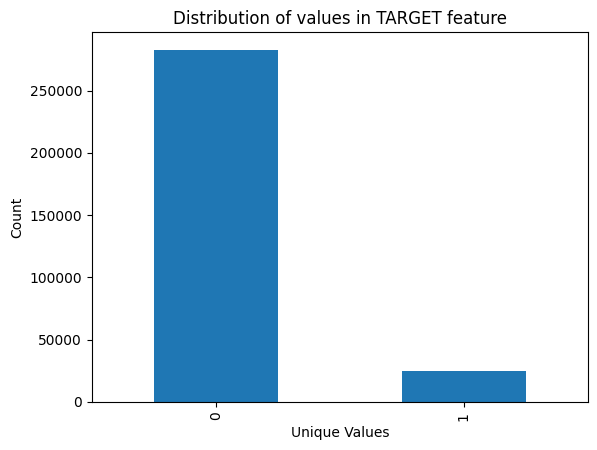

In [ ]:
import matplotlib.pyplot as plt
value_counts =raw_applications['TARGET'].value_counts()
# Assuming 'value_counts' contains the counts of unique values
value_counts.plot(kind='bar')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of values in TARGET feature')
plt.show()

### 2.2. Structural inspection
Using Pandas functions to take a first look at the structure of the dataset

In [ ]:
# Storing a tuple representing the dimensionality of the 'raw_applications' DataFrame, and assigning it to the variable 'raw_applications_shape'
raw_applications_shape = raw_applications.shape

print(f"The 'raw_applications' DataFrame has {raw_applications_shape[0]} rows and {raw_applications_shape[1]} columns")


The 'raw_applications' DataFrame has 307511 rows and 122 columns


In [ ]:
# Printing a concise summary of the raw_applications DataFrame
raw_applications.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


### 2.3. Data types investigation
Utilizing the 'descriptions' DataFrame to help check whether the data types of each column are as expected

In [ ]:
# Storing a deep copy of the 'descriptions' DataFrame's indices and data, and assigning it to the variable 'dtypes_applications'
dtypes_applications = descriptions.copy()

# Storing a Series with the data type of each column in the 'raw_applications' DataFrame inside the 'dtypes_applications' DataFrame, and assigning it to the column 'Data types'
dtypes_applications['Data types'] = raw_applications.dtypes

# Storing a Series containing an array of unique values from each column in the 'raw_applications' DataFrame inside the 'dtypes_applications' DataFrame, and assigning it to the column 'Unique Values'
dtypes_applications['Unique Values'] = raw_applications.apply(lambda c: c.unique())

# Storing a Series containing the number of distinct elements in each column in the 'raw_applications' DataFrame inside the 'dtypes_applications' DataFrame, and assigning it to the column 'Count Unique'
dtypes_applications['Count Unique'] = raw_applications.nunique()

dtypes_applications


Description  \
Column                                                                          
SK_ID_CURR                                           ID of loan in our sample   
TARGET                      Target variable (1 - client with payment diffi...   
NAME_CONTRACT_TYPE                Identification if loan is cash or revolving   
CODE_GENDER                                              Gender of the client   
FLAG_OWN_CAR                                    Flag if the client owns a car   
...                                                                       ...   
AMT_REQ_CREDIT_BUREAU_DAY   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_WEEK  Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_MON   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_QRT   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_YEAR  Number of enquiries to Credit Bureau about the...   

                           Special Data types  \
Column                                          
SK_ID_CURR                     NaN      int64   
TARGET                         NaN      int64   
NAME_CONTRACT_TYPE             NaN     object   
CODE_GENDER                    NaN     object   
FLAG_OWN_CAR                   NaN     object   
...                            ...        ...   
AMT_REQ_CREDIT_BUREAU_DAY      NaN    float64   
AMT_REQ_CREDIT_BUREAU_WEEK     NaN    float64   
AMT_REQ_CREDIT_BUREAU_MON      NaN    float64   
AMT_REQ_CREDIT_BUREAU_QRT      NaN    float64   
AMT_REQ_CREDIT_BUREAU_YEAR     NaN    float64   

                                                                Unique Values  \
Column                                                                          
SK_ID_CURR                  [100002, 100003, 100004, 100006, 100007, 10000...   
TARGET                                                                 [1, 0]   
NAME_CONTRACT_TYPE                              [Cash loans, Revolving loans]   
CODE_GENDER                                                       [M, F, XNA]   
FLAG_OWN_CAR                                                           [N, Y]   
...                                                                       ...   
AMT_REQ_CREDIT_BUREAU_DAY   [0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 9.0, ...   
AMT_REQ_CREDIT_BUREAU_WEEK  [0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, ...   
AMT_REQ_CREDIT_BUREAU_MON   [0.0, nan, 1.0, 2.0, 6.0, 5.0, 3.0, 7.0, 9.0, ...   
AMT_REQ_CREDIT_BUREAU_QRT   [0.0, nan, 1.0, 2.0, 4.0, 3.0, 8.0, 5.0, 6.0, ...   
AMT_REQ_CREDIT_BUREAU_YEAR  [1.0, 0.0, nan, 2.0, 4.0, 5.0, 3.0, 8.0, 6.0, ...   

                            Count Unique  
Column                                    
SK_ID_CURR                        307511  
TARGET                                 2  
NAME_CONTRACT_TYPE                     2  
CODE_GENDER                            3  
FLAG_OWN_CAR                           2  
...                                  ...  
AMT_REQ_CREDIT_BUREAU_DAY              9  
AMT_REQ_CREDIT_BUREAU_WEEK             9  
AMT_REQ_CREDIT_BUREAU_MON             24  
AMT_REQ_CREDIT_BUREAU_QRT             11  
AMT_REQ_CREDIT_BUREAU_YEAR            25  

[122 rows x 5 columns]

#### Manual review of data type suitability for each column in the 'raw_applications' DataFrame

| Column                       | Data types | Expected data type | Suitable? |
|:-----------------------------|:-----------|:-------------------|:----------|
| SK_ID_CURR                   | int64      | Distinct           | Yes       |
| TARGET                       | int64      | Distinct           | Yes       |
| NAME_CONTRACT_TYPE           | object     | Nominal            | Yes       |
| CODE_GENDER                  | object     | Nominal            | Yes       |
| FLAG_OWN_CAR                 | object     | Nominal            | Yes       |
| FLAG_OWN_REALTY              | object     | Nominal            | Yes       |
| CNT_CHILDREN                 | int64      | Distinct           | Yes       |
| AMT_INCOME_TOTAL             | float64    | Distinct           | Yes       |
| AMT_CREDIT                   | float64    | Distinct           | Yes       |
| AMT_ANNUITY                  | float64    | Distinct           | Yes       |
| AMT_GOODS_PRICE              | float64    | Distinct           | Yes       |
| NAME_TYPE_SUITE              | object     | Nominal            | Yes       |
| NAME_INCOME_TYPE             | object     | Nominal            | Yes       |
| NAME_EDUCATION_TYPE          | object     | Ordinal            | Yes       |
| NAME_FAMILY_STATUS           | object     | Nominal            | Yes       |
| NAME_HOUSING_TYPE            | object     | Nominal            | Yes       |
| REGION_POPULATION_RELATIVE   | float64    | Continuous         | Yes       |
| DAYS_BIRTH                   | int64      | Distinct           | Yes       |
| DAYS_EMPLOYED                | int64      | Distinct           | Yes       |
| DAYS_REGISTRATION            | float64    | Distinct           | No        |
| DAYS_ID_PUBLISH              | int64      | Distinct           | Yes       |
| OWN_CAR_AGE                  | float64    | Distinct           | No        |
| FLAG_MOBIL                   | int64      | Nominal            | Yes       |
| FLAG_EMP_PHONE               | int64      | Nominal            | Yes       |
| FLAG_WORK_PHONE              | int64      | Nominal            | Yes       |
| FLAG_CONT_MOBILE             | int64      | Nominal            | Yes       |
| FLAG_PHONE                   | int64      | Nominal            | Yes       |
| FLAG_EMAIL                   | int64      | Nominal            | Yes       |
| OCCUPATION_TYPE              | object     | Nominal            | Yes       |
| CNT_FAM_MEMBERS              | float64    | Distinct           | No        |
| REGION_RATING_CLIENT         | int64      | Ordinal            | Yes       |
| REGION_RATING_CLIENT_W_CITY  | int64      | Ordinal            | Yes       |
| WEEKDAY_APPR_PROCESS_START   | object     | Nominal            | Yes       |
| HOUR_APPR_PROCESS_START      | int64      | Distinct           | Yes       |
| REG_REGION_NOT_LIVE_REGION   | int64      | Nominal            | Yes       |
| REG_REGION_NOT_WORK_REGION   | int64      | Nominal            | Yes       |
| LIVE_REGION_NOT_WORK_REGION  | int64      | Nominal            | Yes       |
| REG_CITY_NOT_LIVE_CITY       | int64      | Nominal            | Yes       |
| REG_CITY_NOT_WORK_CITY       | int64      | Nominal            | Yes       |
| LIVE_CITY_NOT_WORK_CITY      | int64      | Nominal            | Yes       |
| ORGANIZATION_TYPE            | object     | Nominal            | Yes       |
| EXT_SOURCE_1                 | float64    | Continuous         | Yes       |
| EXT_SOURCE_2                 | float64    | Continuous         | Yes       |
| EXT_SOURCE_3                 | float64    | Continuous         | Yes       |
| APARTMENTS_AVG               | float64    | Continuous         | Yes       |
| BASEMENTAREA_AVG             | float64    | Continuous         | Yes       |
| YEARS_BEGINEXPLUATATION_AVG  | float64    | Continuous         | Yes       |
| YEARS_BUILD_AVG              | float64    | Continuous         | Yes       |
| COMMONAREA_AVG               | float64    | Continuous         | Yes       |
| ELEVATORS_AVG                | float64    | Continuous         | Yes       |
| ENTRANCES_AVG                | float64    | Continuous         | Yes       |
| FLOORSMAX_AVG                | float64    | Continuous         | Yes       |
| FLOORSMIN_AVG                | float64    | Continuous         | Yes       |
| LANDAREA_AVG                 | float64    | Continuous         | Yes       |
| LIVINGAPARTMENTS_AVG         | float64    | Continuous         | Yes       |
| LIVINGAREA_AVG               | float64    | Continuous         | Yes       |
| NONLIVINGAPARTMENTS_AVG      | float64    | Continuous         | Yes       |
| NONLIVINGAREA_AVG            | float64    | Continuous         | Yes       |
| APARTMENTS_MODE              | float64    | Continuous         | Yes       |
| BASEMENTAREA_MODE            | float64    | Continuous         | Yes       |
| YEARS_BEGINEXPLUATATION_MODE | float64    | Continuous         | Yes       |
| YEARS_BUILD_MODE             | float64    | Continuous         | Yes       |
| COMMONAREA_MODE              | float64    | Continuous         | Yes       |
| ELEVATORS_MODE               | float64    | Continuous         | Yes       |
| ENTRANCES_MODE               | float64    | Continuous         | Yes       |
| FLOORSMAX_MODE               | float64    | Continuous         | Yes       |
| FLOORSMIN_MODE               | float64    | Continuous         | Yes       |
| LANDAREA_MODE                | float64    | Continuous         | Yes       |
| LIVINGAPARTMENTS_MODE        | float64    | Continuous         | Yes       |
| LIVINGAREA_MODE              | float64    | Continuous         | Yes       |
| NONLIVINGAPARTMENTS_MODE     | float64    | Continuous         | Yes       |
| NONLIVINGAREA_MODE           | float64    | Continuous         | Yes       |
| APARTMENTS_MEDI              | float64    | Continuous         | Yes       |
| BASEMENTAREA_MEDI            | float64    | Continuous         | Yes       |
| YEARS_BEGINEXPLUATATION_MEDI | float64    | Continuous         | Yes       |
| YEARS_BUILD_MEDI             | float64    | Continuous         | Yes       |
| COMMONAREA_MEDI              | float64    | Continuous         | Yes       |
| ELEVATORS_MEDI               | float64    | Continuous         | Yes       |
| ENTRANCES_MEDI               | float64    | Continuous         | Yes       |
| FLOORSMAX_MEDI               | float64    | Continuous         | Yes       |
| FLOORSMIN_MEDI               | float64    | Continuous         | Yes       |
| LANDAREA_MEDI                | float64    | Continuous         | Yes       |
| LIVINGAPARTMENTS_MEDI        | float64    | Continuous         | Yes       |
| LIVINGAREA_MEDI              | float64    | Continuous         | Yes       |
| NONLIVINGAPARTMENTS_MEDI     | float64    | Continuous         | Yes       |
| NONLIVINGAREA_MEDI           | float64    | Continuous         | Yes       |
| FONDKAPREMONT_MODE           | object     | Nominal            | Yes       |
| HOUSETYPE_MODE               | object     | Nominal            | Yes       |
| TOTALAREA_MODE               | float64    | Continuous         | Yes       |
| WALLSMATERIAL_MODE           | object     | Nominal            | Yes       |
| EMERGENCYSTATE_MODE          | object     | Nominal            | Yes       |
| OBS_30_CNT_SOCIAL_CIRCLE     | float64    | Distinct           | No        |
| DEF_30_CNT_SOCIAL_CIRCLE     | float64    | Distinct           | No        |
| OBS_60_CNT_SOCIAL_CIRCLE     | float64    | Distinct           | No        |
| DEF_60_CNT_SOCIAL_CIRCLE     | float64    | Distinct           | No        |
| DAYS_LAST_PHONE_CHANGE       | float64    | Distinct           | No        |
| FLAG_DOCUMENT_2              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_3              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_4              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_5              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_6              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_7              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_8              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_9              | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_10             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_11             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_12             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_13             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_14             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_15             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_16             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_17             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_18             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_19             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_20             | int64      | Nominal            | Yes       |
| FLAG_DOCUMENT_21             | int64      | Nominal            | Yes       |
| AMT_REQ_CREDIT_BUREAU_HOUR   | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_DAY    | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_WEEK   | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_MON    | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_QRT    | float64    | Distinct           | No        |
| AMT_REQ_CREDIT_BUREAU_YEAR   | float64    | Distinct           | No        |


In [ ]:
# Generating descriptive statistics for the numerical columns in the 'raw_applications' DataFrame
raw_applications.describe()


SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

## 3. Data Cleaning

In [ ]:
# Dropping the 'SK_ID_CURR' column from the 'raw_applications' DataFrame
raw_applications.drop(columns='SK_ID_CURR', inplace=True)

### 3.1. Missing values imputation
Utilizing the 'descriptions' DataFrame to find and handle missing missing values

In [ ]:
# Storing a deep copy of the 'descriptions' DataFrame's indices and data, and assigning it to the variable 'missing_applications'
missing_applications = descriptions.copy()

# Storing the sum of a Series with missing values for each column in the 'raw_applications' DataFrame inside the 'missing_applications' DataFrame, and assigning it to the column 'Count NaN/None/NaT'
missing_applications['Count NaN/None/NaT'] = raw_applications.apply(lambda c: c.isnull().sum())

# Calculating the percentage of missing values for each column in the 'raw_applications' DataFrame inside the 'missing_applications' DataFrame, and assigning it to the column 'Count NaN/None/NaT'
missing_applications['Percentage NaN/None/NaT'] = (missing_applications['Count NaN/None/NaT'] / len(raw_applications)) * 100

# Filtering the 'missing_applications' DataFrame so that it only contains columns with more than 0 missing values
missing_applications = missing_applications[missing_applications['Count NaN/None/NaT'] > 0]

# Sort the 'missing_applications' DataFrame in place, by the values in the 'Percentage NaN/None/NaT' column
missing_applications.sort_values(by='Percentage NaN/None/NaT', inplace=True, ascending=False)

missing_applications


<ipython-input-16-ad5f9b089b66>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_applications.sort_values(by='Percentage NaN/None/NaT', inplace=True, ascending=False)


Description  \
Column                                                                        
COMMONAREA_MEDI           Normalized information about building where th...   
COMMONAREA_AVG            Normalized information about building where th...   
COMMONAREA_MODE           Normalized information about building where th...   
NONLIVINGAPARTMENTS_MEDI  Normalized information about building where th...   
NONLIVINGAPARTMENTS_MODE  Normalized information about building where th...   
...                                                                     ...   
EXT_SOURCE_2                     Normalized score from external data source   
AMT_GOODS_PRICE           For consumer loans it is the price of the good...   
AMT_ANNUITY                                                    Loan annuity   
CNT_FAM_MEMBERS                    How many family members does client have   
DAYS_LAST_PHONE_CHANGE    How many days before application did client ch...   

                             Special  Count NaN/None/NaT  \
Column                                                     
COMMONAREA_MEDI           normalized            214865.0   
COMMONAREA_AVG            normalized            214865.0   
COMMONAREA_MODE           normalized            214865.0   
NONLIVINGAPARTMENTS_MEDI  normalized            213514.0   
NONLIVINGAPARTMENTS_MODE  normalized            213514.0   
...                              ...                 ...   
EXT_SOURCE_2              normalized               660.0   
AMT_GOODS_PRICE                  NaN               278.0   
AMT_ANNUITY                      NaN                12.0   
CNT_FAM_MEMBERS                  NaN                 2.0   
DAYS_LAST_PHONE_CHANGE           NaN                 1.0   

                          Percentage NaN/None/NaT  
Column                                             
COMMONAREA_MEDI                         69.872297  
COMMONAREA_AVG                          69.872297  
COMMONAREA_MODE                         69.872297  
NONLIVINGAPARTMENTS_MEDI                69.432963  
NONLIVINGAPARTMENTS_MODE                69.432963  
...                                           ...  
EXT_SOURCE_2                             0.214626  
AMT_GOODS_PRICE                          0.090403  
AMT_ANNUITY                              0.003902  
CNT_FAM_MEMBERS                          0.000650  
DAYS_LAST_PHONE_CHANGE                   0.000325  

[67 rows x 4 columns]

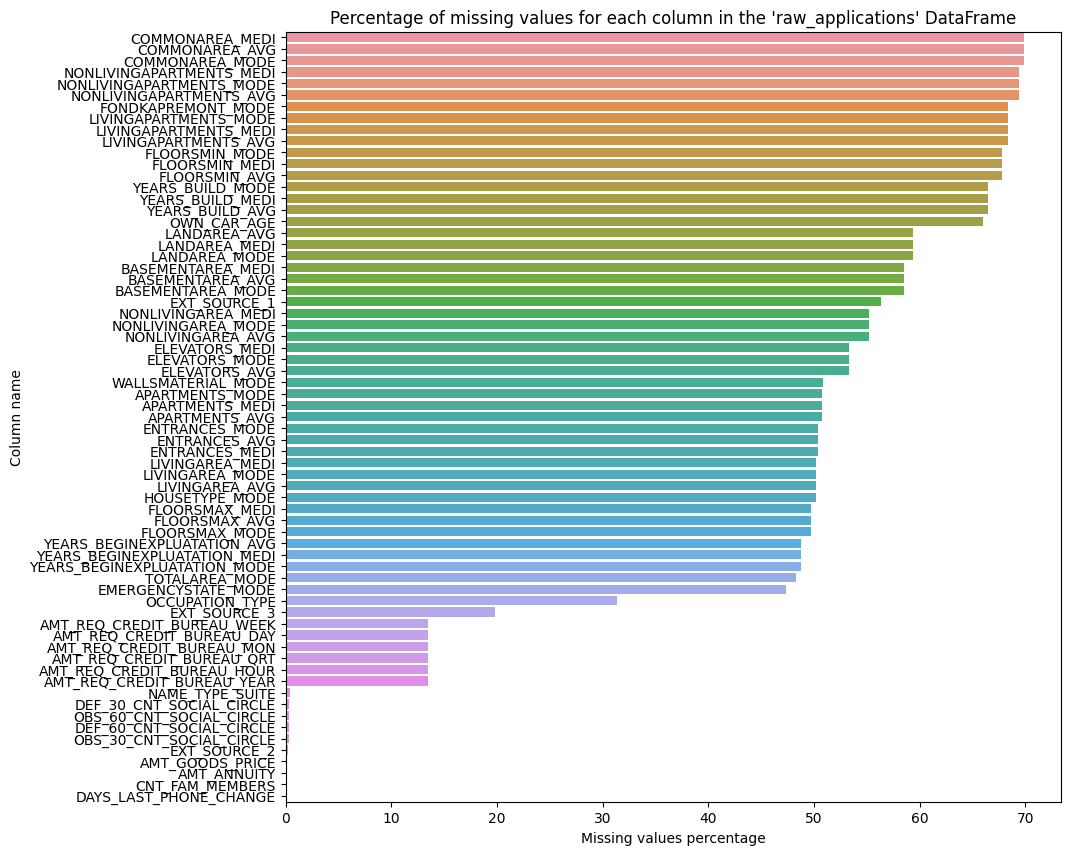

In [ ]:
# Visualising the percentage of missing values for each column in the 'raw_applications' DataFrame
plt.figure(figsize=(10, 10))
plt.title("Percentage of missing values for each column in the 'raw_applications' DataFrame")
sns.barplot(x=missing_applications['Percentage NaN/None/NaT'], y=missing_applications.index)
plt.xlabel("Missing values percentage")
plt.ylabel("Column name")
plt.show()


#### A brief word on the 'Missingness Mechanism'
We conducted an extensive investigation into the nature of missingness for out dataset but eventually concluded that it was not necessary.
Using 'Little's MCAR test' we found that the entire data frame could be classified as 'MCAR' (Missing completely at random) but there were
small groups of similar columns, identified by plotting a missingness matrix, whos missingness was clearly extremely closely linked and
when tested using Little's MCAR test were found to contain data not missing completely at random with p values reaching as low as 0.000001.
We decided not to investigate further as it was taking far too much time, and we were not asked to do this in any lecture.

#### Our strategy for dealing with missing values
As can be seen in the figure above, the columns within our dataset have largely varying amounts of missing data. This means there is really
no 'one solution to fit all' here. We therefore decided, due to the fact that our investigation into missingness was abandoned, to be rather
blunt with our approach to handling missing values. We initially planned to create some kind of formula that looked at each column and
combined its feature importance (defined by Spearman's rank correlation coefficient) with its proportion of missing values to calculate
whether to drop the column, impute it, or drop rows with missing values. This task however proved far too time consuming.

With all of this in mind, here are the criteria we followed when dealing with missing values in our data-set:

| Percentage of missing values in column | Strategy                                                                     |
|----------------------------------------|------------------------------------------------------------------------------|
| >33%                                   | Drop the entire column                                                       |
| >=3% and <=33%                         | Impute missing values using either median or mode depending on the data type |
| 0-3%                                   | Drop any rows in which values are missing                                    |




In [ ]:
# Sorting the columns with missing values into lists according to how they will be dealt with.

total_columns = len(raw_applications.columns)
columns_with_missing = (raw_applications.isnull().sum() > 0).sum()

columns_over_33 = missing_applications['Percentage NaN/None/NaT'] > 33
columns_to_drop = columns_over_33[columns_over_33].index.tolist()

columns_in_range_3_33 = (missing_applications['Percentage NaN/None/NaT'] >= 3) & (missing_applications['Percentage NaN/None/NaT'] <= 33)
columns_to_impute = columns_in_range_3_33[columns_in_range_3_33].index.tolist()

columns_under_3_not_0 = (missing_applications['Percentage NaN/None/NaT'] > 0) & (missing_applications['Percentage NaN/None/NaT'] < 3)
columns_drop_rows = columns_under_3_not_0[columns_under_3_not_0].index.tolist()

print(f"Of the {total_columns} columns in the 'raw_applications' DataFrame, missing values are present in {columns_with_missing} (~{round((columns_with_missing / total_columns) * 100)}%)\n")
print(f"{len(columns_to_drop)} columns are missing >33% of their values and will be dropped\n")
print(f"{len(columns_to_impute)} columns are missing from >=3% and <=33% of their values and will be imputed\n")
print(f"{len(columns_drop_rows)} columns are missing from >0% and <3% of their values. Rows missing values in these columns will be dropped\n")


Of the 121 columns in the 'raw_applications' DataFrame, missing values are present in 67 (~55%)

49 columns are missing >33% of their values and will be dropped

8 columns are missing from >=3% and <=33% of their values and will be imputed

10 columns are missing from >0% and <3% of their values. Rows missing values in these columns will be dropped



In [ ]:
# Dealing with missing values as described above
clean_applications = raw_applications.drop(columns=columns_to_drop)

clean_applications.dropna(subset=columns_drop_rows, inplace=True)

for column in columns_to_impute:
    if column == "OCCUPATION_TYPE":
        mode_value = clean_applications[column].mode()[0]
        clean_applications[column].fillna(mode_value, inplace=True)
    else:
        median_value = clean_applications[column].median()
        clean_applications[column].fillna(median_value, inplace=True)

print(f"There are now {clean_applications.isnull().sum().sum()} missing values in the 'clean_applications' DataFrame\n")

# Storing a tuple representing the dimensionality of the 'clean_applications' DataFrame, and assigning it to the variable 'clean_applications_shape'
clean_applications_shape = clean_applications.shape

print(f"The 'clean_applications' DataFrame has {clean_applications_shape[0]} rows and {clean_applications_shape[1]} columns")


There are now 0 missing values in the 'clean_applications' DataFrame

The 'clean_applications' DataFrame has 304531 rows and 72 columns


In [ ]:
# Creating a DataFrame of columns with the data type 'object' from the 'clean_applications' DataFrame
object_columns = clean_applications.select_dtypes(include=['object'])

#
object_columns_value_counts = object_columns.apply(lambda c: c.value_counts().to_dict())
object_columns_value_counts

NAME_CONTRACT_TYPE             {'Cash loans': 276613, 'Revolving loans': 27918}
CODE_GENDER                                {'F': 200482, 'M': 104045, 'XNA': 4}
FLAG_OWN_CAR                                         {'N': 200910, 'Y': 103621}
FLAG_OWN_REALTY                                       {'Y': 211641, 'N': 92890}
NAME_TYPE_SUITE               {'Unaccompanied': 247112, 'Family': 39969, 'Sp...
NAME_INCOME_TYPE              {'Working': 157341, 'Commercial associate': 70...
NAME_EDUCATION_TYPE           {'Secondary / secondary special': 216582, 'Hig...
NAME_FAMILY_STATUS            {'Married': 194660, 'Single / not married': 44...
NAME_HOUSING_TYPE             {'House / apartment': 270243, 'With parents': ...
OCCUPATION_TYPE               {'Laborers': 150165, 'Sales staff': 31790, 'Co...
WEEKDAY_APPR_PROCESS_START    {'TUESDAY': 53399, 'WEDNESDAY': 51418, 'MONDAY...
ORGANIZATION_TYPE             {'Business Entity Type 3': 67270, 'XNA': 54852...
dtype: object

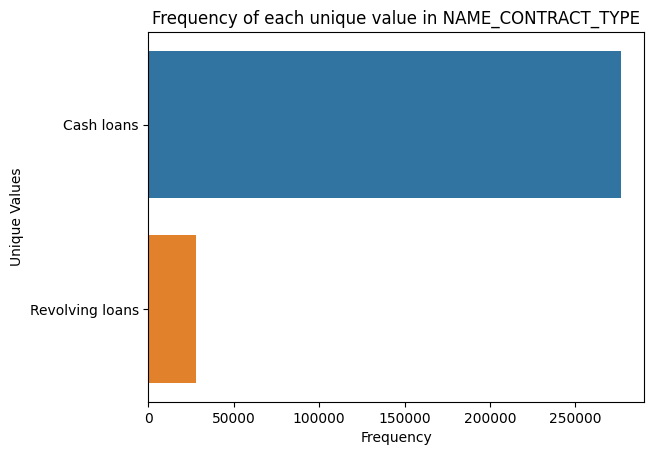

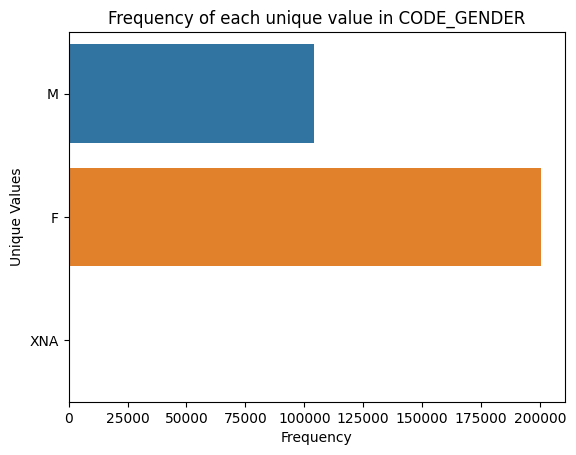

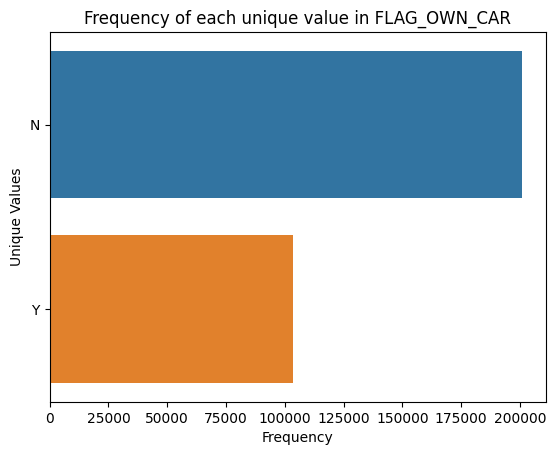

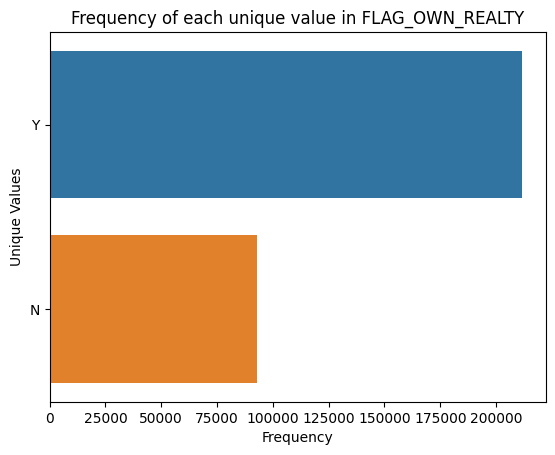

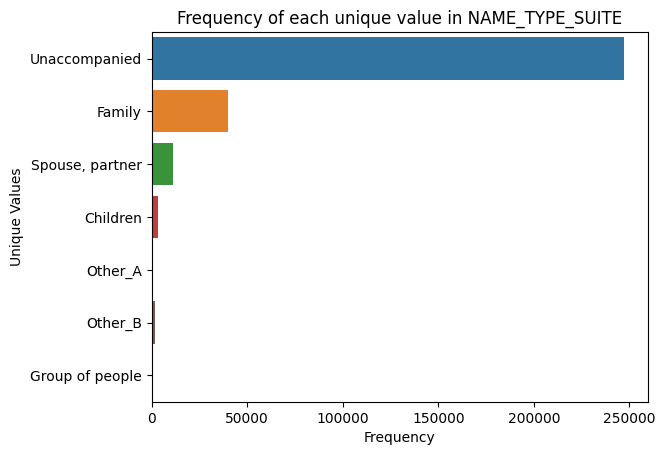

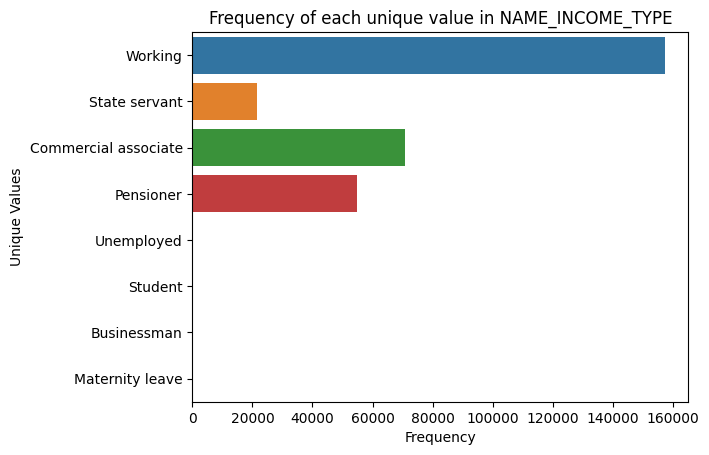

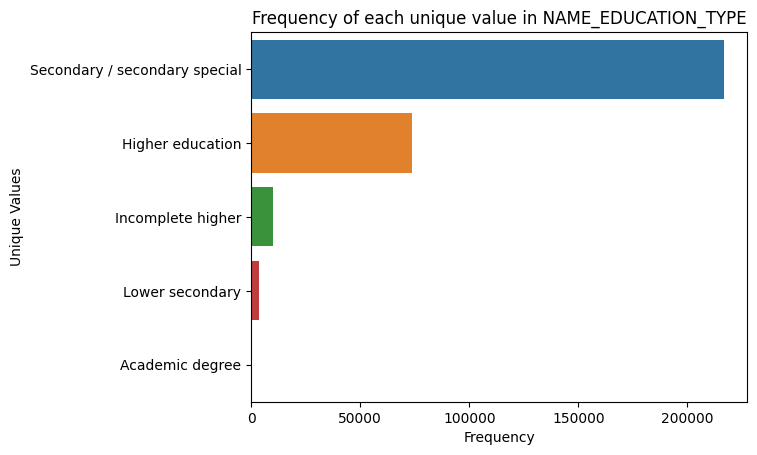

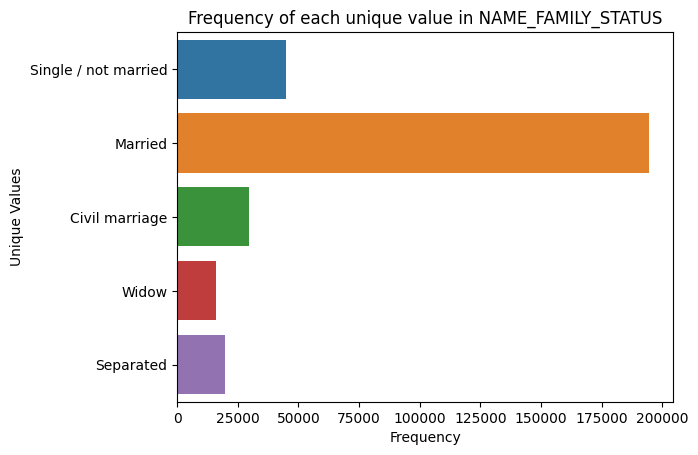

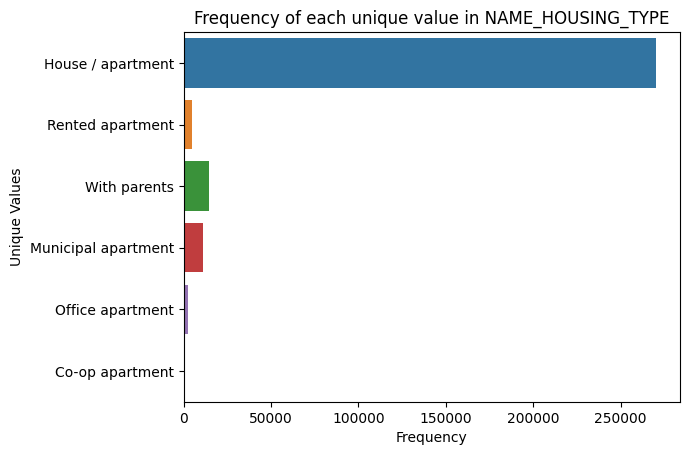

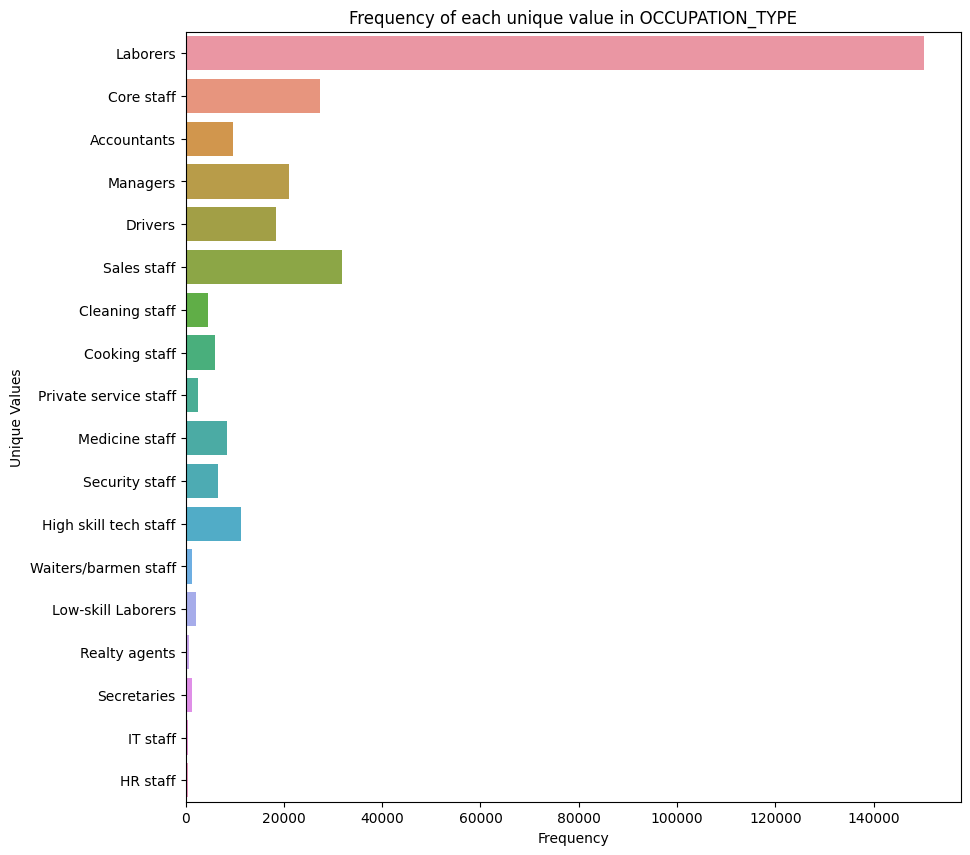

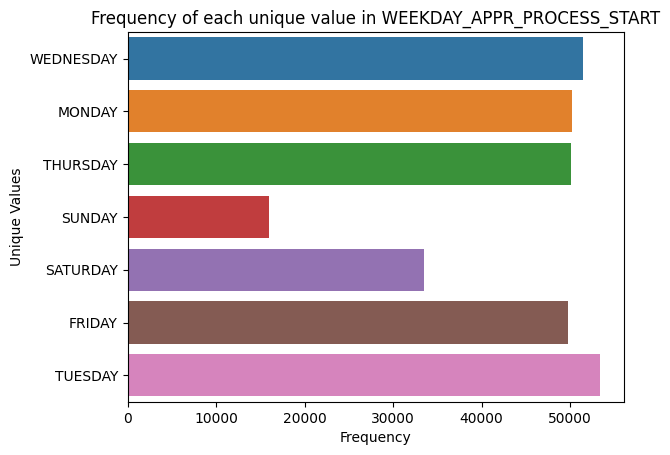

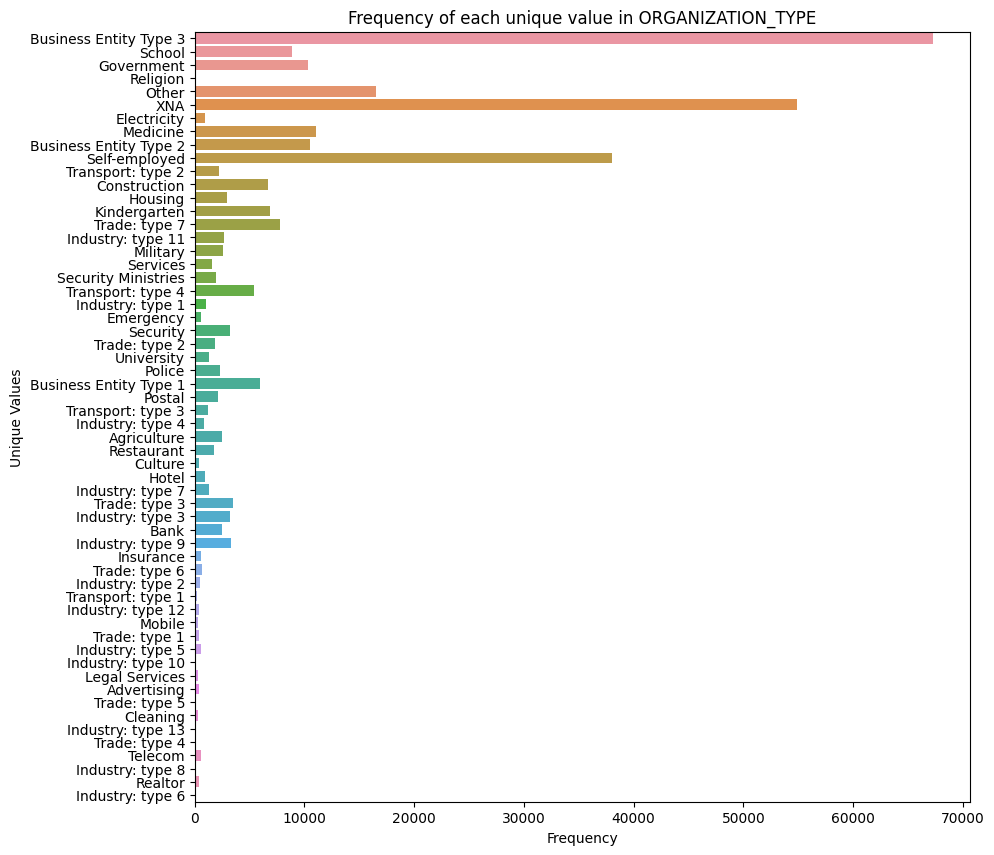

In [ ]:
# Visualising
for column in object_columns:
  if column in ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']:
    plt.figure(figsize=(10, 10))
    plt.title(f"Frequency of each unique value in {column}")
    sns.countplot(y=clean_applications[column])
    plt.xlabel("Frequency")
    plt.ylabel("Unique Values")
    plt.show()
  else:
    plt.title(f"Frequency of each unique value in {column}")
    sns.countplot(y=clean_applications[column])
    plt.xlabel("Frequency")
    plt.ylabel("Unique Values")
    plt.show()

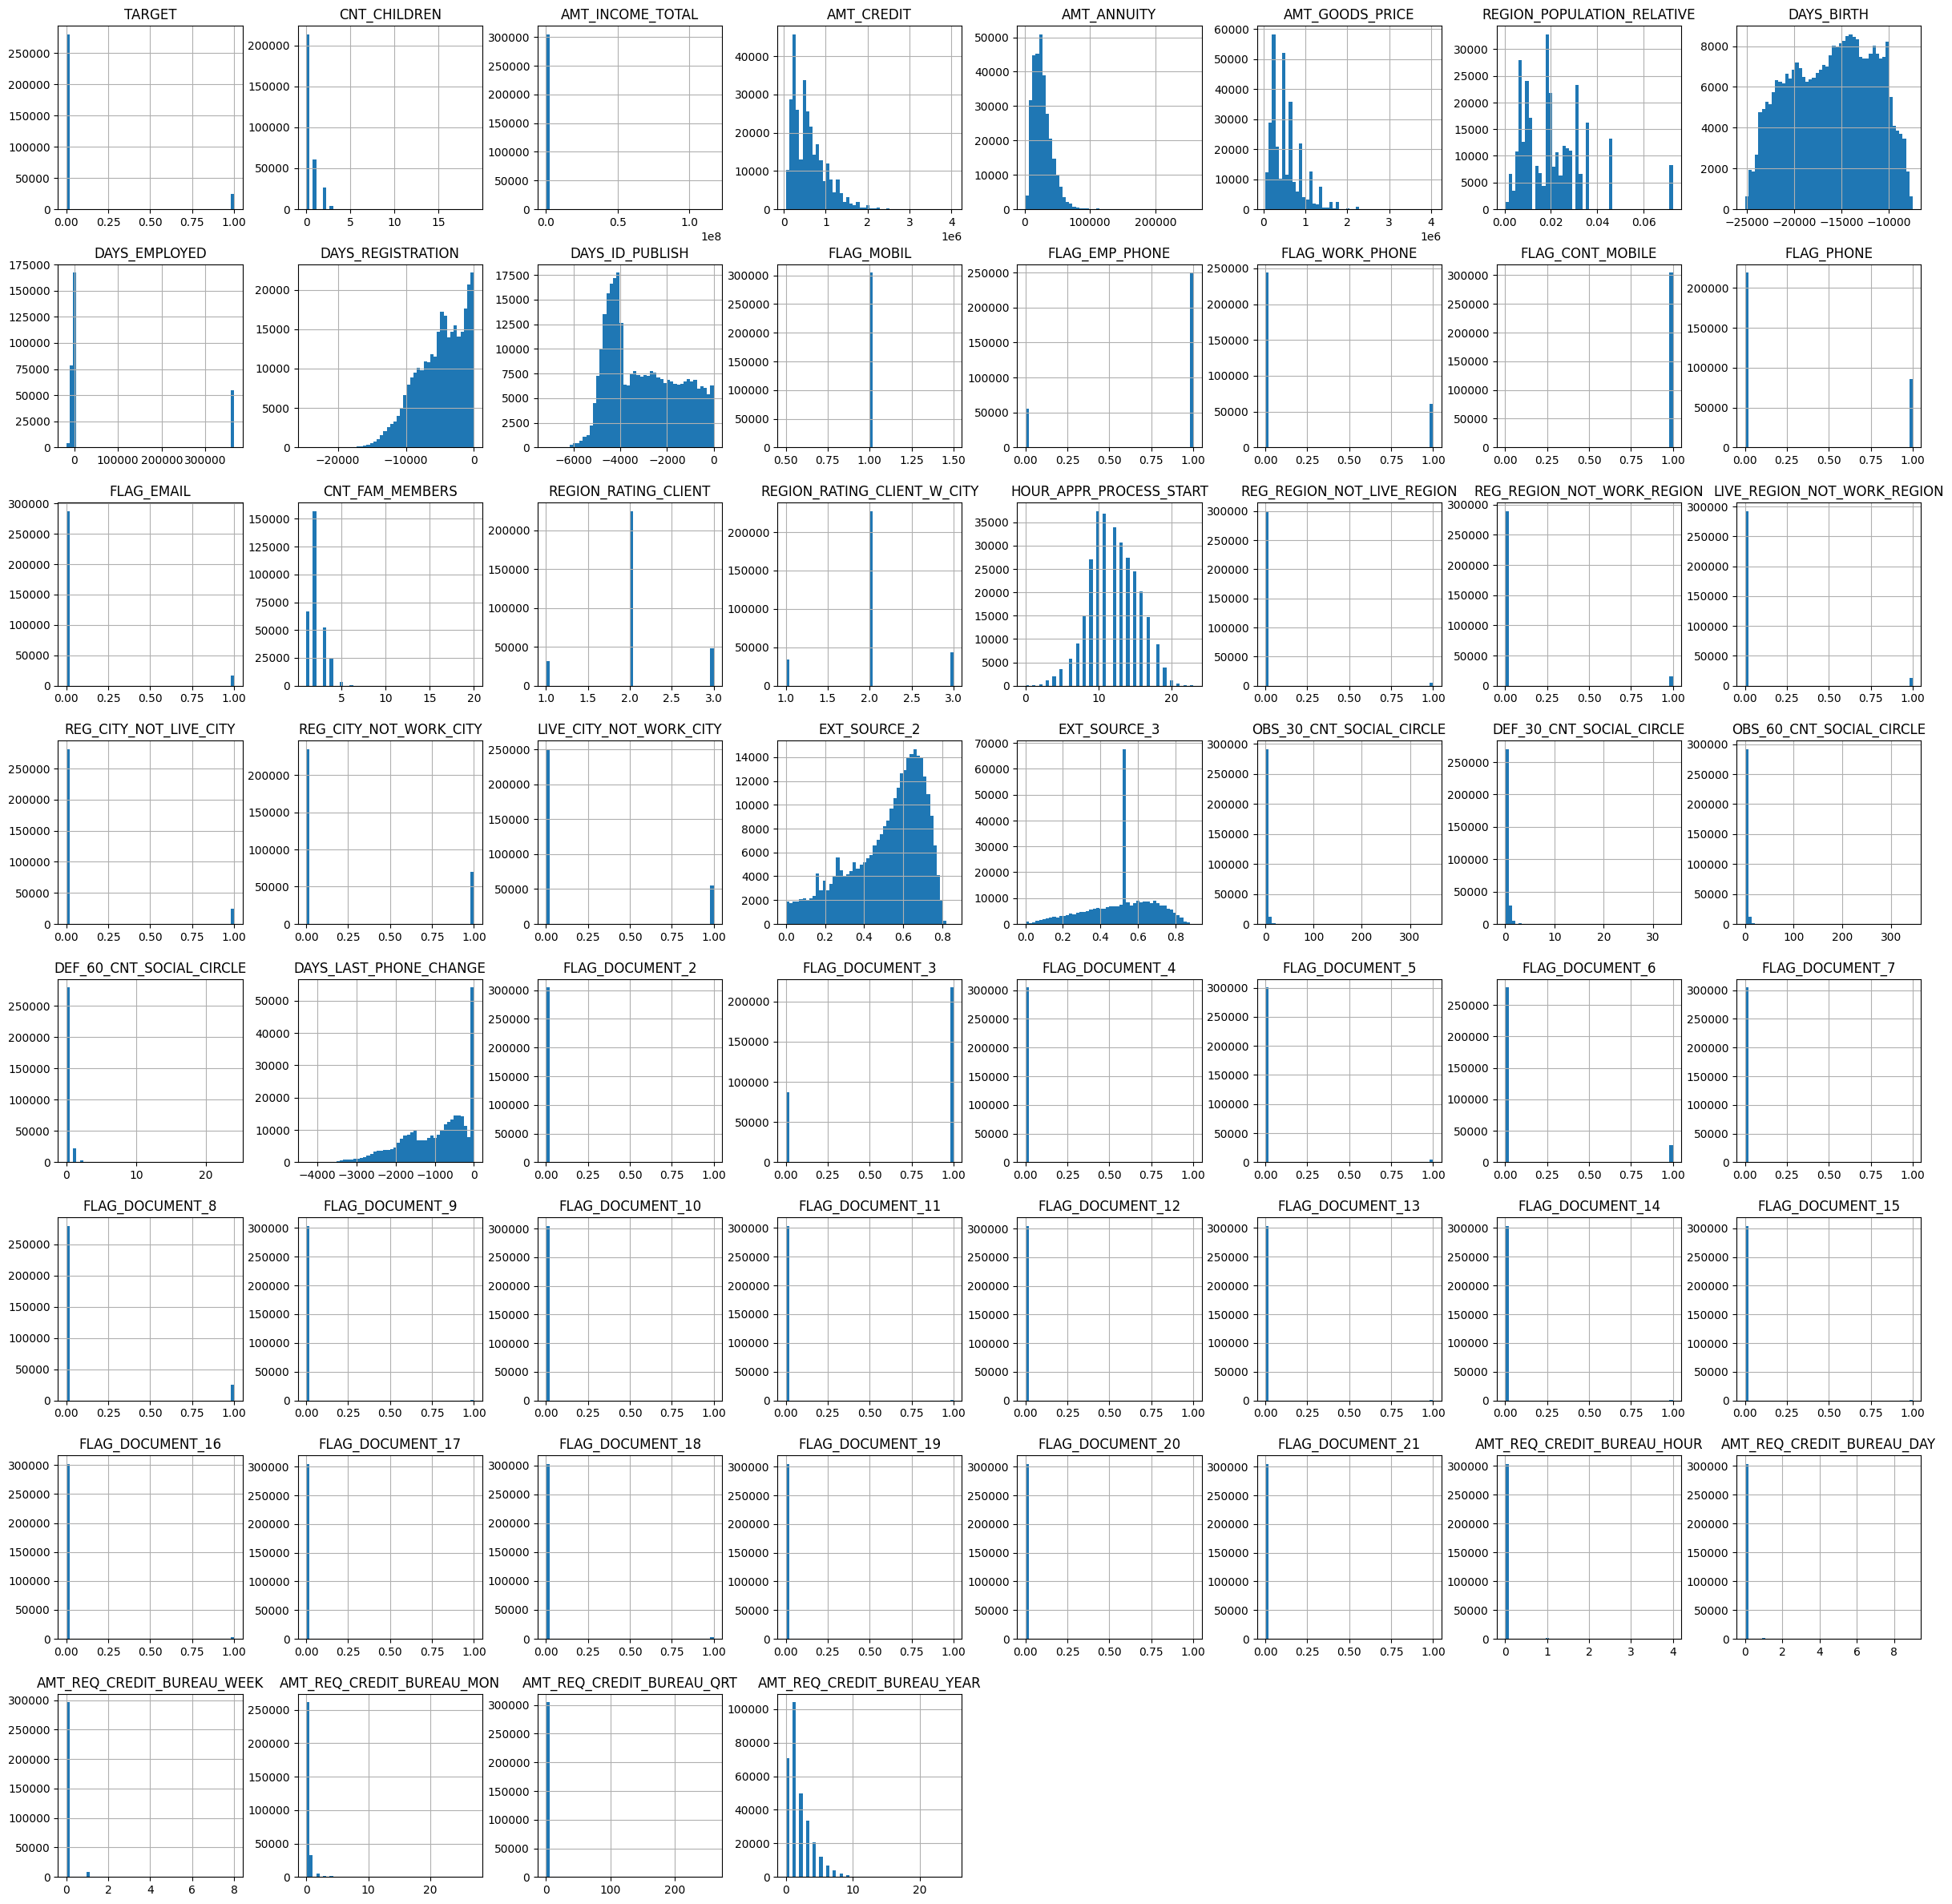

In [ ]:
# Creating a DataFrame of columns with the data type 'int64' or 'float64' from the 'clean_applications' DataFrame
numerical_columns = clean_applications.select_dtypes(include=['int64', 'float64'])

numerical_columns.hist(figsize=(30, 30), bins=50)
plt.show()

In [ ]:
# Removing XNA values in the CODE_GENDER feature as this does not seem to represent any valid values related to gender
clean_applications = clean_applications[clean_applications['CODE_GENDER'] != 'XNA']

In [ ]:
# Assigning ordinal values to the 'NAME_EDUCATION_TYPE' from the 'raw_applications' DataFrame
education_ordinal = {'Academic degree': 1, 'Higher education': 2, 'Incomplete higher': 3, 'Secondary / secondary special': 4, 'Lower secondary': 5}
clean_applications['NAME_EDUCATION_TYPE'] = clean_applications['NAME_EDUCATION_TYPE'].map(education_ordinal)

# Assigning binary values to the columns in the 'raw_applications' DataFrame that contain binary data
clean_applications['CODE_GENDER'].replace({'M': 1, 'F': 0}, inplace=True)
clean_applications['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0}, inplace=True)
clean_applications['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0}, inplace=True)

<ipython-input-24-3eb63ce4f531>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_applications['NAME_EDUCATION_TYPE'] = clean_applications['NAME_EDUCATION_TYPE'].map(education_ordinal)


In [ ]:
# Binning for OCCUPATION_TYPE and ORGANIZATION_TYPE to reduce dimensionality
default_rate_OCCUPATION_TYPE = clean_applications.groupby('OCCUPATION_TYPE')['TARGET'].mean()
default_rate_ORGANIZATION_TYPE = clean_applications.groupby('ORGANIZATION_TYPE')['TARGET'].mean()
default_rate_OCCUPATION_TYPE_bin = pd.cut(default_rate_OCCUPATION_TYPE, bins=4, labels=[4,3,2,1])
default_rate_ORGANIZATION_TYPE_bin = pd.cut(default_rate_ORGANIZATION_TYPE, bins=4, labels=[4,3,2,1])
clean_applications['ORGANIZATION_TYPE'].replace(default_rate_ORGANIZATION_TYPE_bin,inplace=True)
clean_applications['OCCUPATION_TYPE'].replace(default_rate_OCCUPATION_TYPE_bin, inplace=True)
# default_rate_ORGANIZATION_TYPE_bin_dict = default_rate_ORGANIZATION_TYPE_bin.to_dict()
#
# for i in clean_applications['ORGANIZATION_TYPE'].unique():
#     clean_applications.replace(i, default_rate_ORGANIZATION_TYPE_bin_dict[i], inplace=True)

# default_rate_OCCUPATION_TYPE_bin_dict = default_rate_OCCUPATION_TYPE_bin.to_dict()
#
# for i in clean_applications['OCCUPATION_TYPE'].unique():
#     clean_applications.replace(i, default_rate_OCCUPATION_TYPE_bin_dict[i], inplace=True)

# default_rate_OCCUPATION_TYPE_bin

# Accountants,4
# Secretaries,4
# Core staff,4
# Realty agents,4
# HR staff,4
# High skill tech staff,4
# IT staff,4
# Private service staff,4
# Medicine staff,4
# Managers,4
# Sales staff,3
# Laborers,3
# Security staff,3
# Cooking staff,3
# Cleaning staff,3
# Drivers,2
# Waiters/barmen staff,2
# Low-skill Laborers,


# default_rate_ORGANIZATION_TYPE_bin

# XNA,4
# Military,4
# Police,4
# Industry: type 12,4
# Religion,4
# School,4
# Security Ministries,4
# University,4
# Trade: type 4,4
# Insurance,4
# Trade: type 5,4
# Trade: type 6,4
# Transport: type 1,4
# Culture,4
# Bank,4
# Trade: type 2,3
# Legal Services,3
# Medicine,3
# Transport: type 4,3
# Mobile,3
# Postal,3
# Transport: type 2,3
# Trade: type 7,3
# Telecom,3
# Trade: type 1,3
# Other,3
# Services,3
# Advertising,3
# Kindergarten,3
# Hotel,3
# Housing,3
# Industry: type 9,3
# Electricity,3
# Industry: type 10,3
# Government,3
# Business Entity Type 3,3
# Industry: type 11,3
# Industry: type 2,3
# Business Entity Type 1,3
# Industry: type 5,3
# Industry: type 6,3
# Industry: type 7,3
# Business Entity Type 2,3
# Emergency,3
# Cleaning,2
# Construction,2
# Agriculture,2
# Industry: type 8,2
# Industry: type 1,2
# Security,2
# Restaurant,2
# Realtor,2
# Industry: type 3,2
# Industry: type 4,2
# Trade: type 3,2
# Self-employed,2
# Industry: type 13,1
# Transport: type 3,1


### 3.2. Outliers handling
Investigating and handling outliers using visual and non-visual methods

In [ ]:
#Define function to filter out numeric outliers using z_score
def filter_outliers(col, threshold=3):
    if col.name in [i for i in list(numerical_columns.columns) if i != 'TARGET']:
        z_scores = np.abs(col - col.mean()) / col.std()
        col_copy = col.copy()  #Create a copy of the column to avoid modifying the original
        col_copy[z_scores >= threshold] = col.mean() + threshold * col.std()  #Replace outliers on positive side
        col_copy[z_scores <= -threshold] = col.mean() - threshold * col.std()  #Replace outliers on negative side
        return col_copy
    else:
        return col
#Filter out only numeric col
clean_applications = clean_applications.apply(filter_outliers, axis=0)

### 3.3. Encoding categorical data

In [ ]:
# Creating a DataFrame of columns with the data type 'object' from the 'clean_applications' DataFrame
object_columns = clean_applications.select_dtypes(include=['object'])

#
object_columns_value_counts = object_columns.apply(lambda c: c.value_counts().to_dict())

In [ ]:
# Creating dummy variables for categorical columns
clean_applications = pd.get_dummies(clean_applications, columns=object_columns.columns)

## 4. Feature Engineering

We will try to make a few new features from the traditionally important features in the dataset. The features that we will use as input will include:
+ **EXT_SOURCE_1/2/3**: Normalized score from external data source 1,2,3 - We dropped the EXT_SOURCE_1 due to the feature was missing over 50%
+ AMT_ANNUITY: Loan annuity
+ AMT_CREDIT: Credit amount of the loan
+ AMT_INCOME_TOTAL: Income of the client
+ AMT_GOODS_PRICE: For consumer loans it is the price of the goods for which the loan is given
+ DAYS_EMPLOYED: How many days before the application the person started current employment
+ CNT_FAM_MEMBERS: How many family members does client have
+ DAYS_EMPLOYED: How many days before the application the person started current employment
+ DAYS_BIRTH: Client's age in days at the time of application

Explaining the engineered features:
1. EXT_MEAN/EXT_STD: not everyone have their profiles at all 3 external sources, hence by aggregating from multiple sources we will be able to build a more in-depth understanding of the individual - Even though we remove EXT_SOURCE_1 due to excessive missing values, by incoporating the data into the engineered features we can still retain this knowledge
2. GOOD_CREDIT: How much was the purchase financed by credit
3. ANNUITY_INCOME: How much of the customer's income will be spend on paying back for the loan
4. CREDIT_INCOME: The size of the credit compare to the customer's income
5. CNT_FAM_INCOM: The total income divided by the size of family - so a person cam have a high personal income buy a bigger size family may suggest more or less level of expenses
6. INCOME_EMPLOYED: The ratio between level of income comparing to level of work experience. Someone can be incredibly young but they may have a level of income excedding their peers
7. INCOME_BIRTH: The ratio between level of income comparing to actual age - Elder citizen may have substantial personal saving but lack thereoff may indicate a much dire situation


In [ ]:
#Engineering key features from the applications dataset
def engineered_apps(data, raw):

    data['EXT_MEAN'] = raw[[ 'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    data['EXT_STD'] = raw[[ 'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    data['EXT_STD'] = data['EXT_STD'].fillna(data['EXT_STD'].median())
    data['GOODS_CREDIT'] = raw['AMT_GOODS_PRICE']/raw['AMT_CREDIT']
    data['ANNUITY_INCOME'] = raw['AMT_ANNUITY']/raw['AMT_INCOME_TOTAL']
    data['CREDIT_INCOME'] = raw['AMT_CREDIT']/raw['AMT_INCOME_TOTAL']
    data['CNT_FAM_INCOME'] = raw['AMT_INCOME_TOTAL']/raw['CNT_FAM_MEMBERS']
    data['INCOME_EMPLOYED'] = raw['AMT_INCOME_TOTAL']/raw['DAYS_EMPLOYED']
    data['INCOME_BIRTH'] = raw['AMT_INCOME_TOTAL']/raw['DAYS_BIRTH']

    return data

clean_applications = engineered_apps(clean_applications, raw_applications)

### Handling infinity values

In [ ]:
# Check for infinity
is_infinity = clean_applications.isin([float("inf"), float("-inf")])


# Identify columns with infinity
columns_with_infinity = is_infinity.any()

print("Columns with infinity:")
print(clean_applications.loc[:,columns_with_infinity].columns)

Columns with infinity:
Index(['INCOME_EMPLOYED'], dtype='object')


In [ ]:
# Name of the column with infinity values
column_name = 'INCOME_EMPLOYED'
clean_applications = clean_applications[~np.isinf(clean_applications[column_name])]

## 5. Scaling the dataset

Since we already remove outlier in section 3 so we could use minmaxscaler or StandardScaler without worry about outlier skewing the result. Since our features have different units so we will go with StandardScaler. This choice also consider the implementation of Kmean-clustering in the unsupervised portion

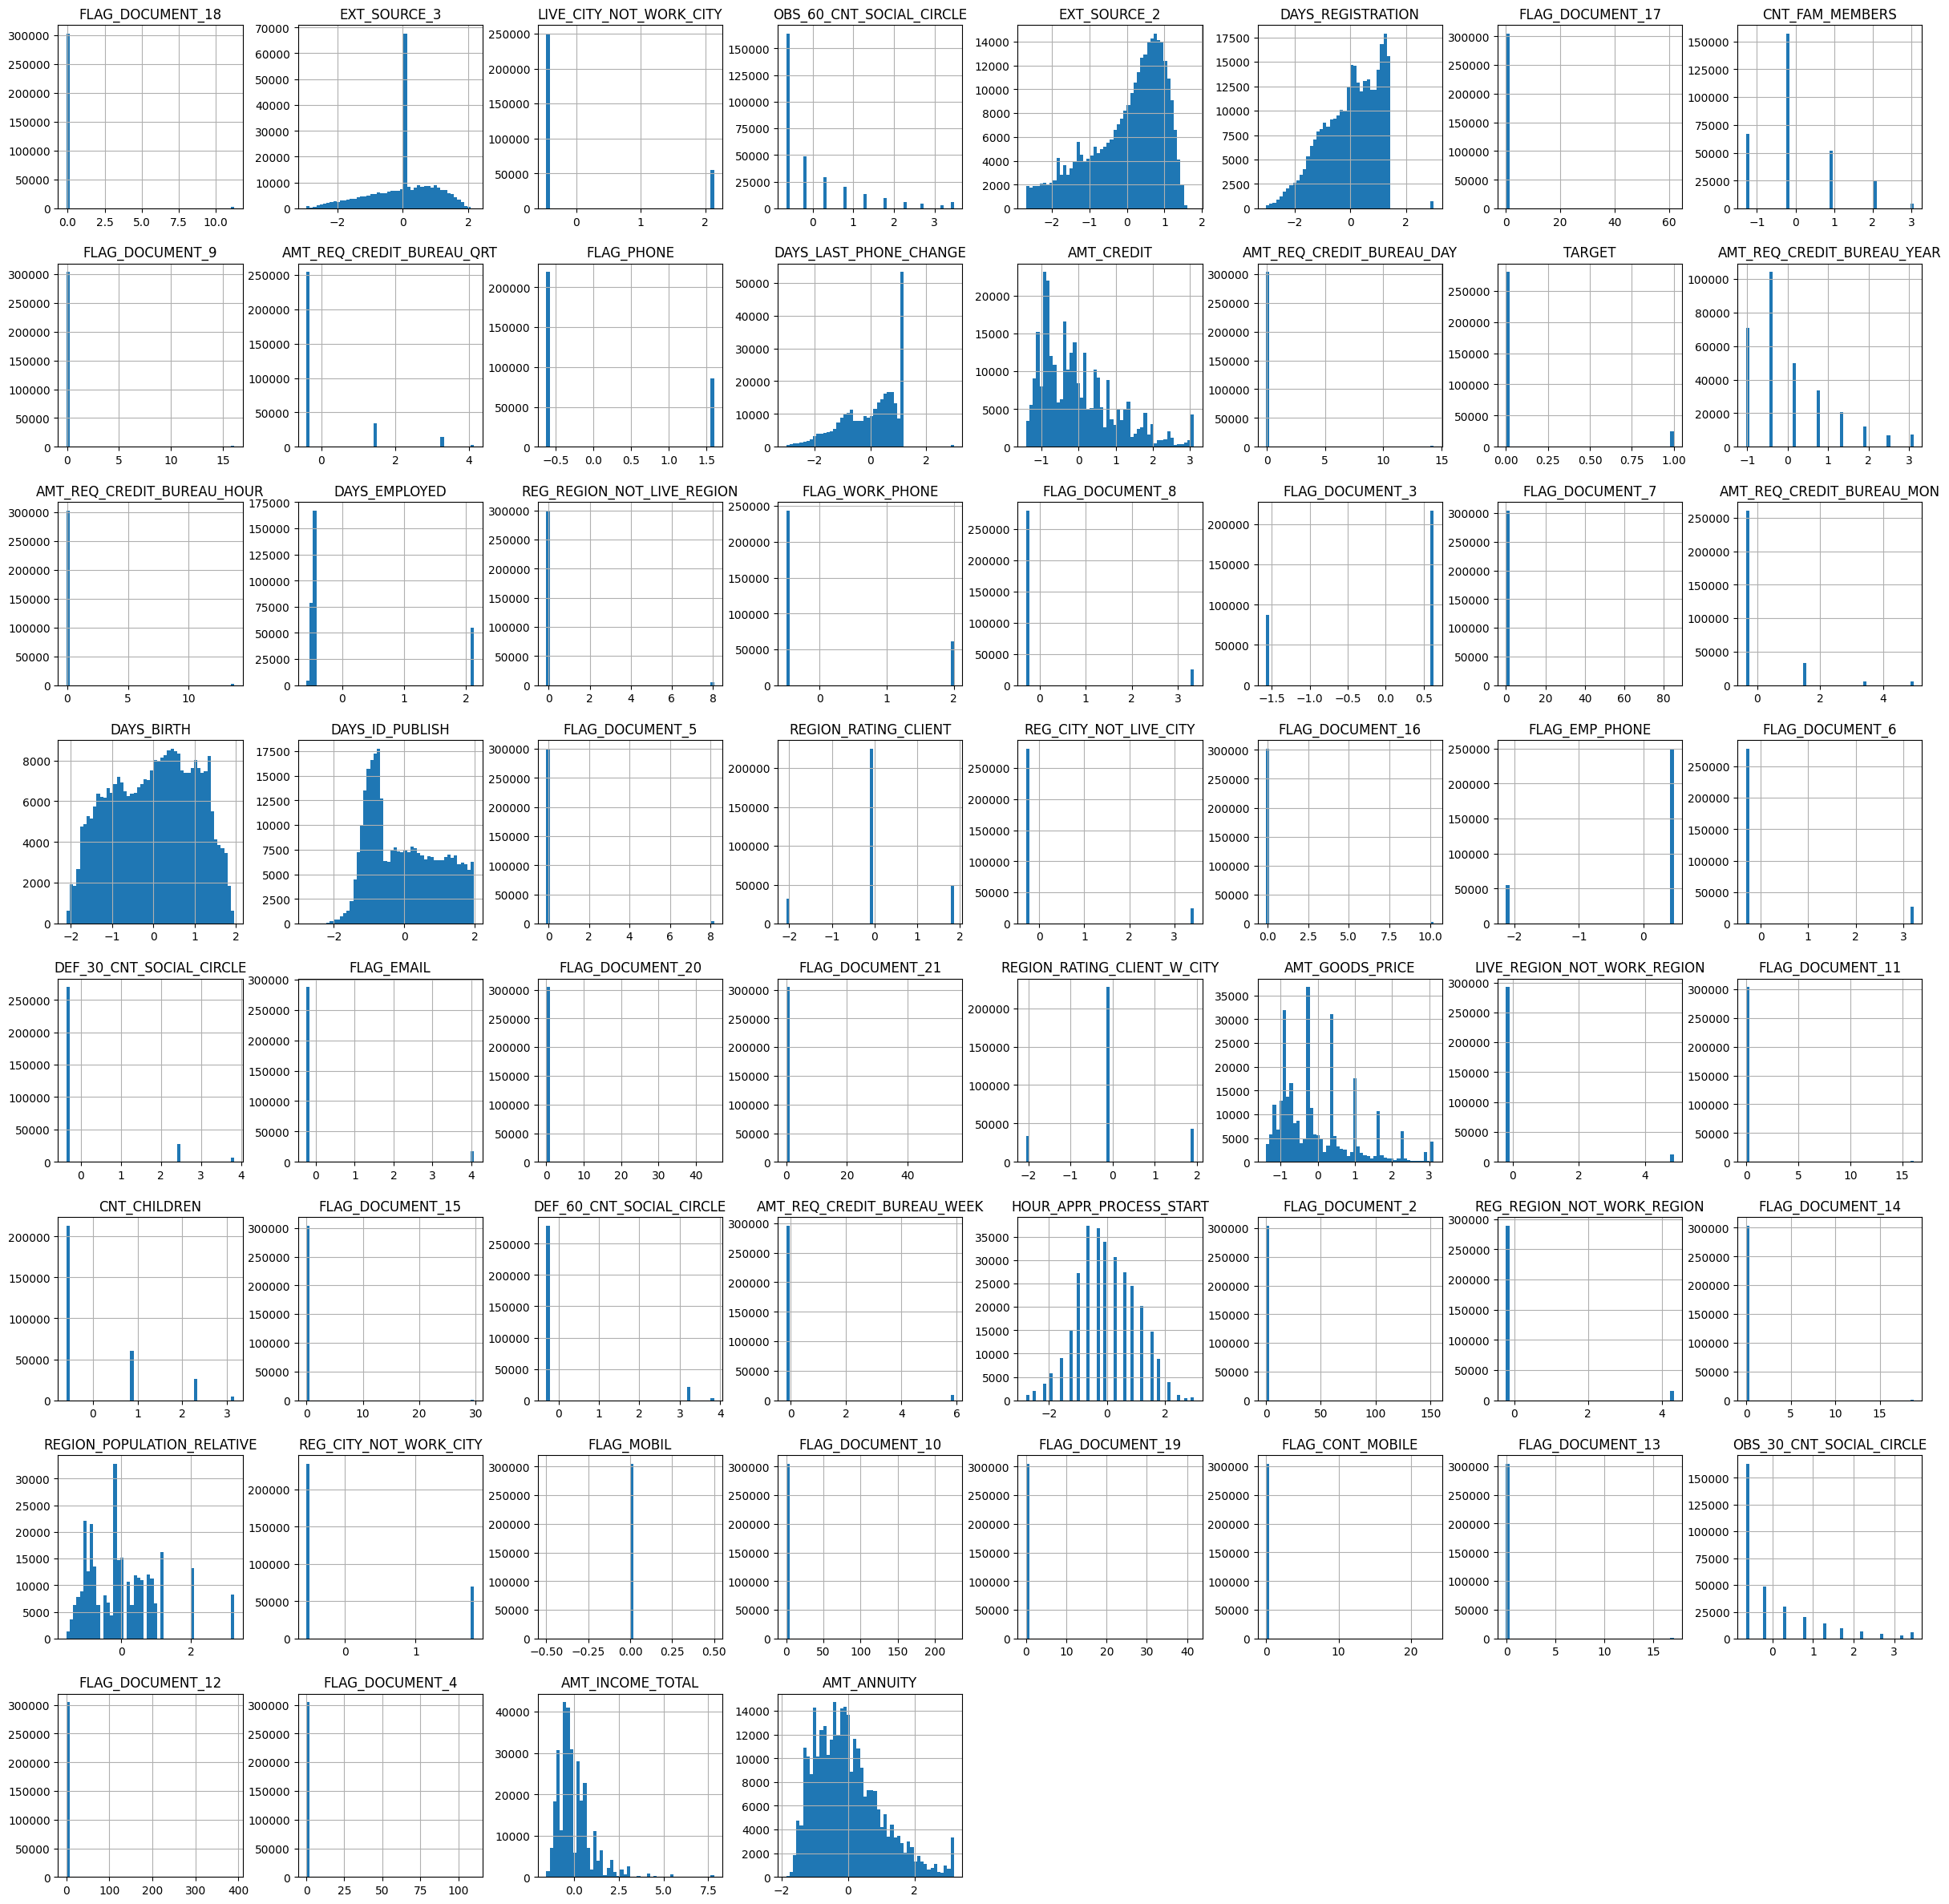

In [ ]:
#Splitting the dataset into dependent and independent
clean_applications_independent = copy.deepcopy(clean_applications.drop('TARGET', axis= 1))
clean_target = clean_applications['TARGET']


# Scaled the data using the MinMax method
scaler = StandardScaler()
scaler.fit(clean_applications_independent)

# Scale only the data part
df_scaled = scaler.transform(clean_applications_independent)

# Merging to make a clean DataFrame with 'TARGET' included
df_clean = pd.DataFrame(df_scaled, columns=clean_applications.columns[1:,])
df_clean['TARGET'] = clean_target.reset_index(drop=True)  # Reset the index to ensure proper alignment


# Graph the numerical col to see the distribution after scaling
raw_applications.select_dtypes(include=['int64', 'float64']).columns
numerical_columns_raw = raw_applications.select_dtypes(include=['int64', 'float64']).columns
numerical_columns_clean = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Find the common numerical columns
common_numerical_columns = list(set(numerical_columns_raw) & set(numerical_columns_clean))
# Creating a DataFrame of columns with the data type 'int64' or 'float64' from the 'clean_applications' DataFrame
numerical_columns = df_clean[common_numerical_columns]

numerical_columns.hist(figsize=(30, 30), bins=50)
plt.show()

**** May consider delete the below box plot
This visualizaiton aim to indicate the distribution of quantitative features all fall into a normal range with few outlier affecting the model

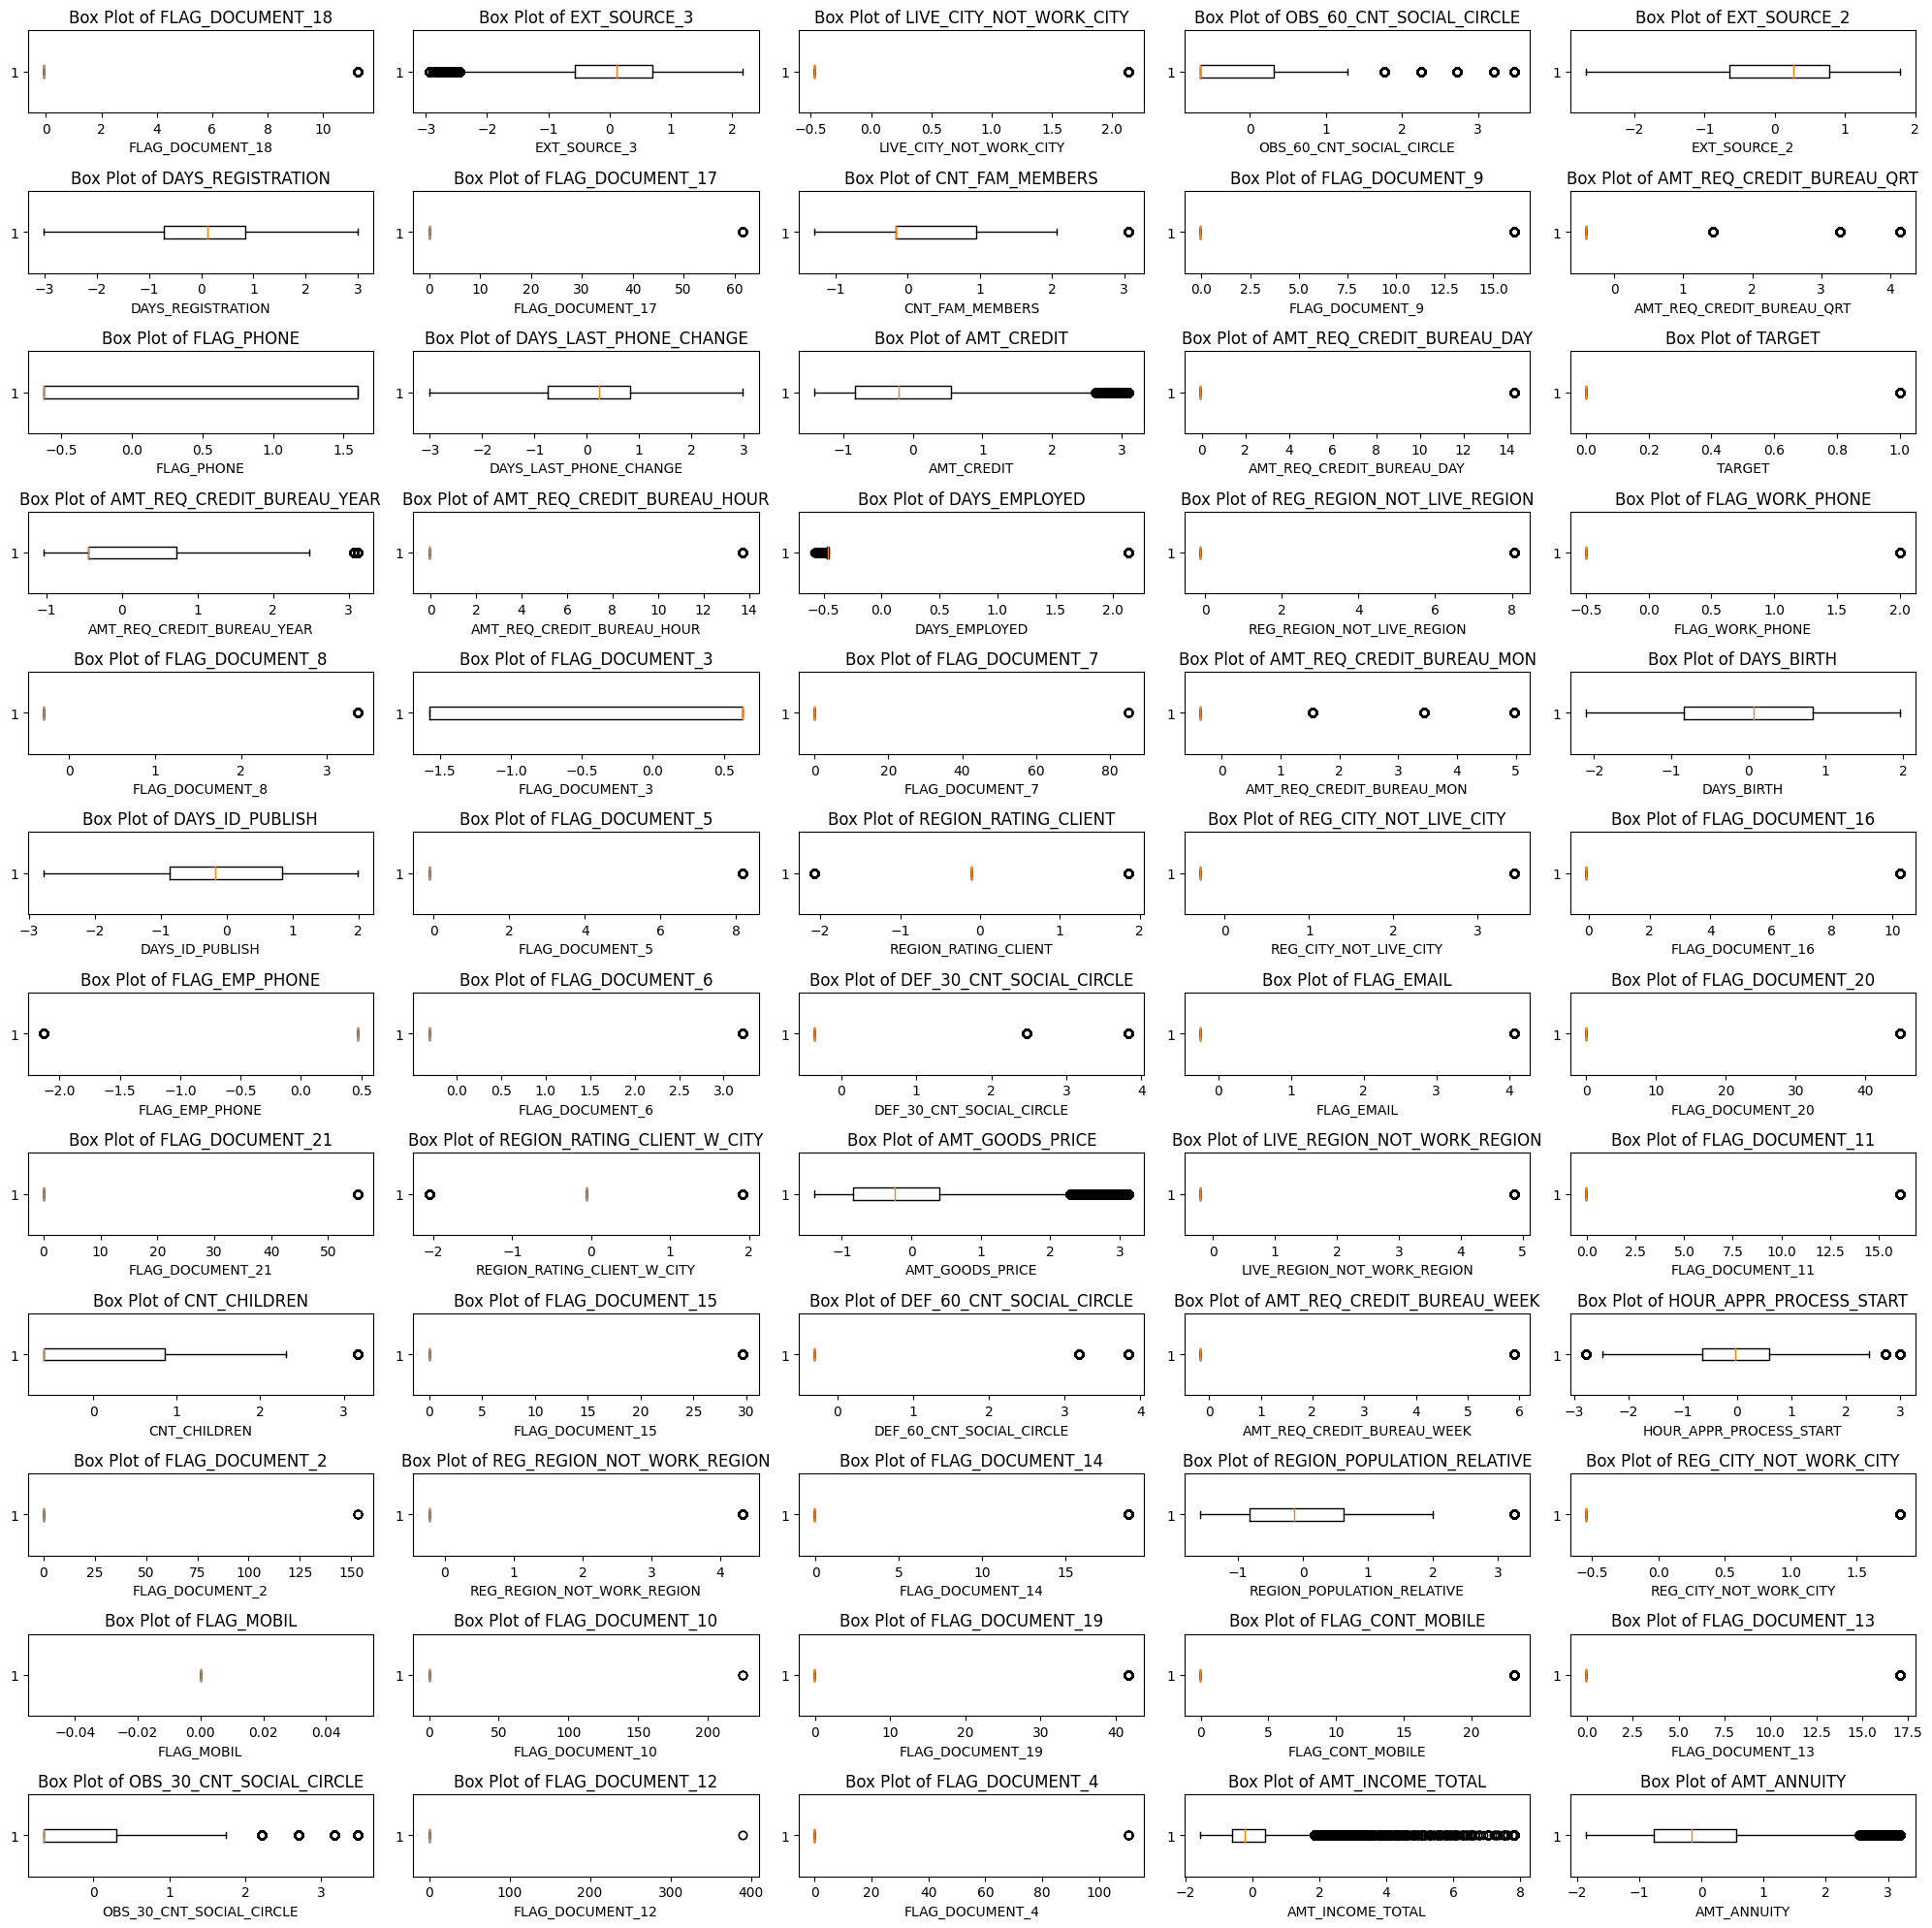

In [ ]:
# Calculate the total number of plots
total_plots = numerical_columns.shape[1]

# Divide the plot into rows of 5
num_cols = 5
num_rows = int(total_plots / num_cols)

# Create a figure and set size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Create boxplot and place them
for i, column in enumerate(numerical_columns.columns):
    ax = axes[i // num_cols, i % num_cols]  # Select the appropriate subplot
    ax.boxplot(numerical_columns[column], vert=False)
    ax.set_title(f'Box Plot of {column}')
    ax.set_xlabel(column)

# Remove empty subplots
for i in range(total_plots, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
clean_applications

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0            1            1             0                1           0.0   
1            0            0             0                0           0.0   
2            0            1             1                1           0.0   
3            0            0             0                1           0.0   
4            0            1             0                1           0.0   
...        ...          ...           ...              ...           ...   
307506       0            1             0                0           0.0   
307507       0            0             0                1           0.0   
307508       0            0             0                1           0.0   
307509       1            0             0                1           0.0   
307510       0            0             0                0           0.0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0               202500.0    406597.5      24700.5         351000.0   
1               270000.0   1293502.5      35698.5        1129500.0   
2                67500.0    135000.0       6750.0         135000.0   
3               135000.0    312682.5      29686.5         297000.0   
4               121500.0    513000.0      21865.5         513000.0   
...                  ...         ...          ...              ...   
307506          157500.0    254700.0      27558.0         225000.0   
307507           72000.0    269550.0      12001.5         225000.0   
307508          153000.0    677664.0      29979.0         585000.0   
307509          171000.0    370107.0      20205.0         319500.0   
307510          157500.0    675000.0      49117.5         675000.0   

        NAME_EDUCATION_TYPE  ...  WEEKDAY_APPR_PROCESS_START_TUESDAY  \
0                         4  ...                                   0   
1                         2  ...                                   0   
2                         4  ...                                   0   
3                         4  ...                                   0   
4                         4  ...                                   0   
...                     ...  ...                                 ...   
307506                    4  ...                                   0   
307507                    4  ...                                   0   
307508                    2  ...                                   0   
307509                    4  ...                                   0   
307510                    2  ...                                   0   

        WEEKDAY_APPR_PROCESS_START_WEDNESDAY  EXT_MEAN   EXT_STD  \
0                                          1  0.161787  0.092026   
1                                          0  0.466757  0.219895   
2                                          0  0.642739  0.122792   
3                                          1  0.650442  0.136053   
4                                          0  0.322738  0.136053   
...                                      ...       ...       ...   
307506                                     0  0.413601  0.379053   
307507                                     0  0.115992  0.136053   
307508                                     0  0.499536  0.264447   
307509                                     1  0.587593  0.103846   
307510                                     0  0.518984  0.351032   

        GOODS_CREDIT  ANNUITY_INCOME  CREDIT_INCOME  CNT_FAM_INCOME  \
0           0.863262        0.121978       2.007889        202500.0   
1           0.873211        0.132217       4.790750        135000.0   
2           1.000000        0.100000       2.000000         67500.0   
3           0.949845        0.219900       2.316167         67500.0   
4           1.000000        0.179963       4.222222        121500.0   
...              ...             ...            ...             ...   
307506      0.883392        0.174971       1.617143        157500.0   
3075

## 6. Unsupervised learning

Performing unsupervised learning on the full dataset may be very computationally intenseive so we will just try to explore on a small subset

In [ ]:
#Running k-mean clustering on the whole dataframe might be too heavy so we will choose most correlated features only
correlations = df_clean.corr()['TARGET'].abs().sort_values(ascending=False)

#Taking the top most correlated features, excluding the TARGET feature itself
top_15_correlated = correlations[1:16].index.tolist()

#Extract the corresponding columns from the DataFrame
df_top15 = df_clean[top_15_correlated]

In [ ]:
df_top15.isnull().sum()

EXT_MEAN                       0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
DAYS_BIRTH                     0
GOODS_CREDIT                   0
ORGANIZATION_TYPE              0
REGION_RATING_CLIENT_W_CITY    0
REGION_RATING_CLIENT           0
NAME_INCOME_TYPE_Working       0
NAME_EDUCATION_TYPE            0
CODE_GENDER                    0
OCCUPATION_TYPE                0
DAYS_LAST_PHONE_CHANGE         0
DAYS_ID_PUBLISH                0
REG_CITY_NOT_WORK_CITY         0
dtype: int64

Observing the most correlated features with TARGET, we observe a few details:
1. EXT_MEAN is better than the individual EXT_SOURCE 2,3 so it would seem the engineered feature helps
2. DAYS_BIRTH is the next most correlated feature (we will use this for the unsupervised portion)
3. After cleaning and reformat, ORGANIZATION_TYPE and OCCUPATION_TYPE has a better correlation with TARGET
4. REGION_RATIN_CLIEANT_W_CITY and REGION_RATING_CLIENT are relatively high and would suggest to further experimental to remove certain discrimination in the lending process

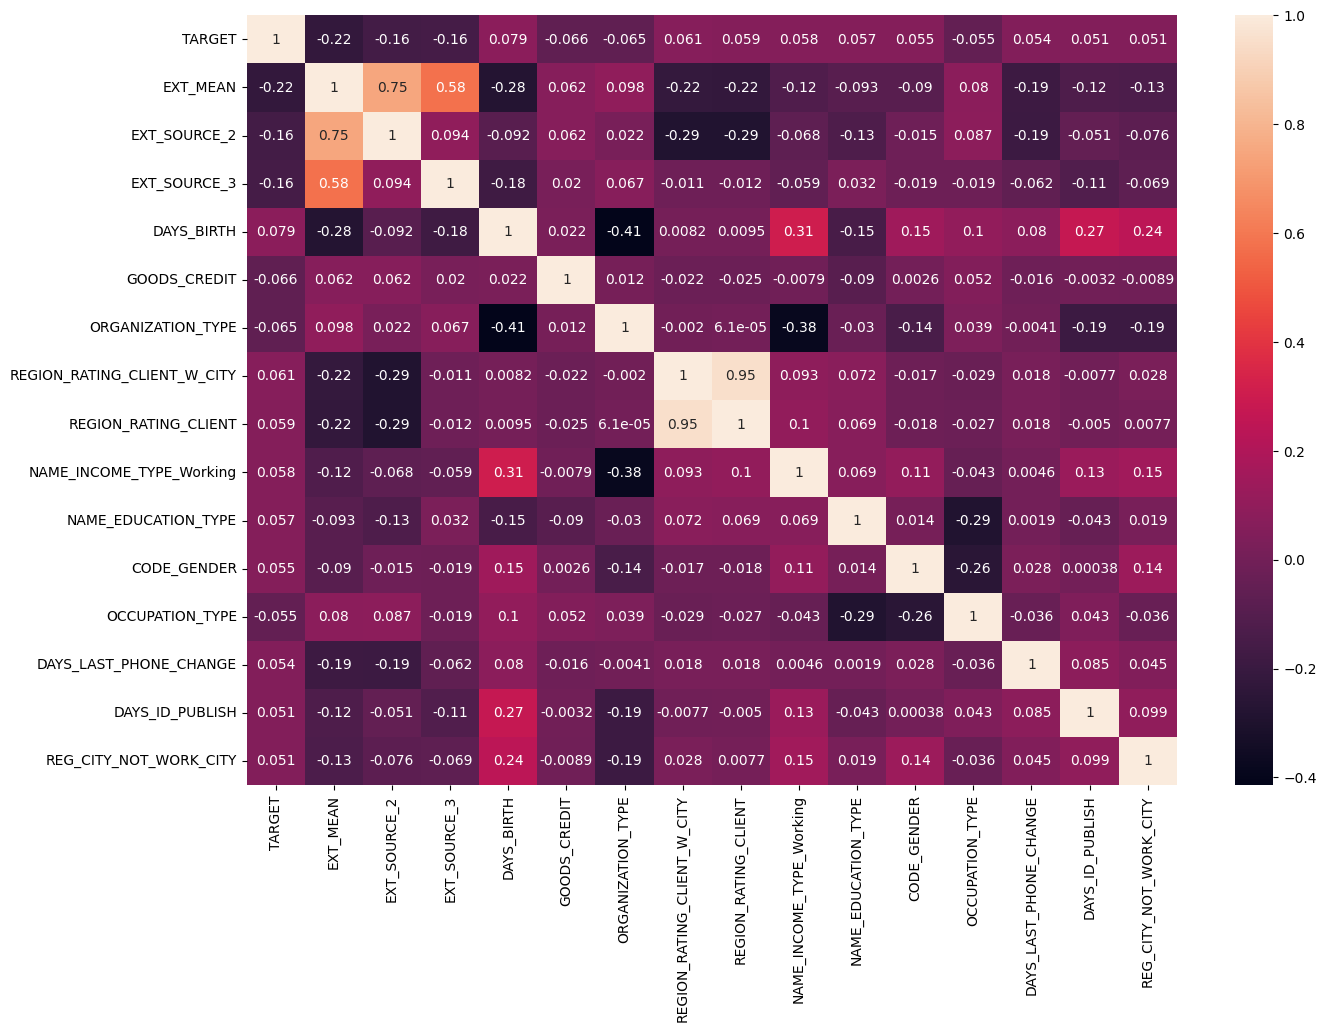

In [ ]:
3# Drawing a heat map of correlation between TARGET and the top 15 features
plt.figure(figsize = (15, 10))
target_corr = df_clean[correlations[:16].index.tolist()].corr() #including TARGET too
sns.heatmap(target_corr, annot = True)
plt.show()

We are dealing with a binary classification problem so we already expect there to be 2 cluster in the dataset. So now we will perform K-means unsupervised learning on the dataset at 3 different level of detail of the dataset:
- Full features
- Using top 15 most correlated features to TARGET
- Using only 2 most correlated features to TARGET: EXT_MEAN and DAYS_BIRTH
and then cross-reference with the actual TARGET value to see if there exist any visible distinction.

In the case of using all features and 15 features, we will also ultilize PCA to find a simpler 2D representation of the clusters.
Since the size of the dataset is relatively big so we will create a sample using random undersampler for a faster calculation

In [ ]:
#Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=20)
x_sample = df_clean.drop('TARGET', axis=1)
y_sample = df_clean['TARGET']

#Perform undersampling
x_sample, y_sample = undersampler.fit_resample(x_sample, y_sample)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


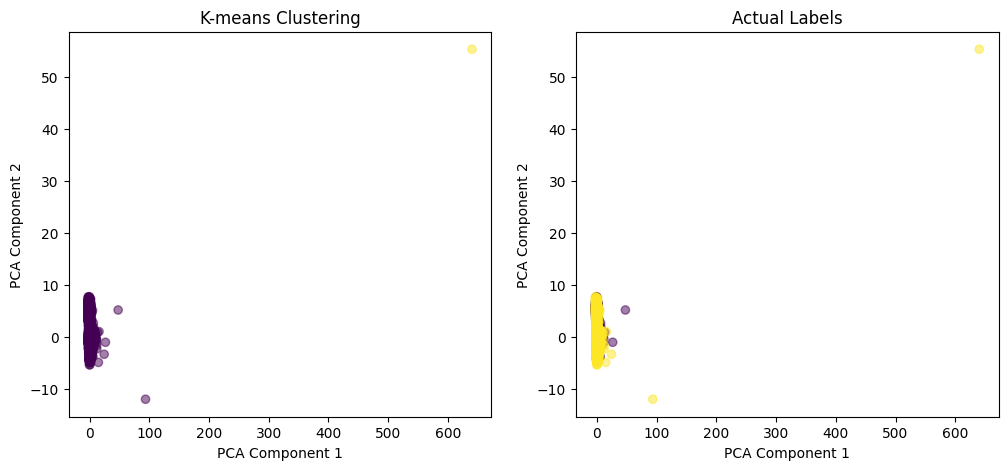

Completeness score 0.05871070982411073
Homogeneity score 2.027111454095166e-05


In [ ]:
#Fitting the K-Means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(x_sample)

# Get the K-Means cluster labels
kmeans_labels = kmeans.labels_

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(x_sample)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: K-means Clustering
axs[0].scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
axs[0].set_title("K-means Clustering")
axs[0].set_xlabel('PCA Component 1')
axs[0].set_ylabel('PCA Component 2')

# Subplot 2: Actual Labels
axs[1].scatter(reduced_features[:, 0], reduced_features[:, 1], c=  y_sample, alpha= 0.5)
axs[1].set_title("Actual Labels")
axs[1].set_xlabel('PCA Component 1')
axs[1].set_ylabel('PCA Component 2')
plt.show()
#Calculating different metric for the clusters
#completeness score
print("Completeness score", metrics.completeness_score(y_sample, kmeans_labels))
#homogeneity scores
print("Homogeneity score", metrics.homogeneity_score(y_sample, kmeans_labels))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


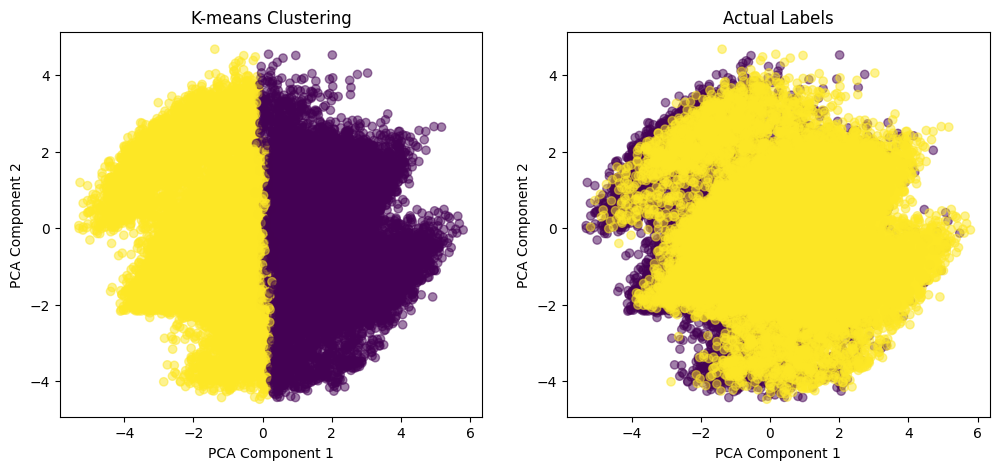

Completeness score 0.07784772210080235
Homogeneity score 0.07760231635034778


In [ ]:
sample_top15 =  x_sample[top_15_correlated]

#Fitting the K-Means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(sample_top15)

# Get the K-Means cluster labels
kmeans_labels = kmeans.labels_

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(sample_top15)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: K-means Clustering
axs[0].scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
axs[0].set_title("K-means Clustering")
axs[0].set_xlabel('PCA Component 1')
axs[0].set_ylabel('PCA Component 2')

# Subplot 2: Actual Labels
axs[1].scatter(reduced_features[:, 0], reduced_features[:, 1], c=  y_sample, alpha= 0.5)
axs[1].set_title("Actual Labels")
axs[1].set_xlabel('PCA Component 1')
axs[1].set_ylabel('PCA Component 2')
plt.show()

#Calculating different metric for the clusters
#completeness score
print("Completeness score", metrics.completeness_score(y_sample, kmeans_labels))
#homogeneity scores
print("Homogeneity score", metrics.homogeneity_score(y_sample, kmeans_labels))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


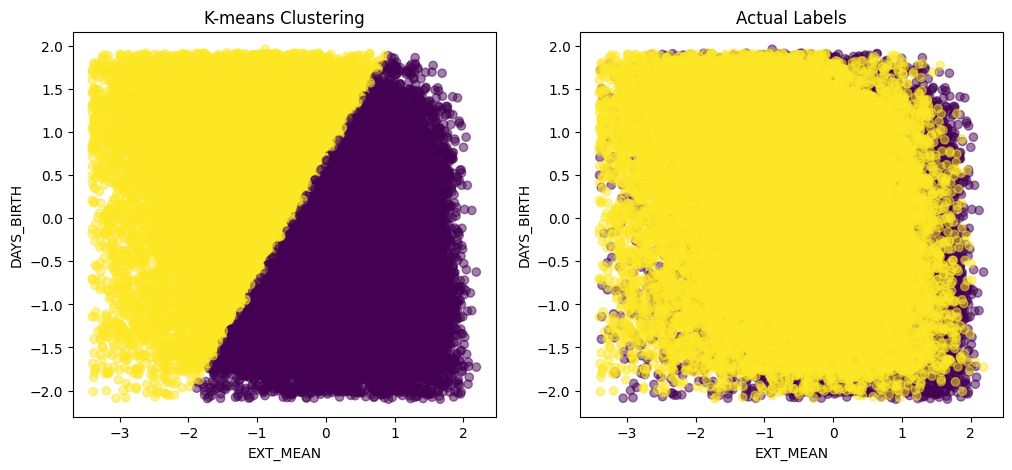

Completeness score 0.06268325896890722
Homogeneity score 0.06261273617818945


In [ ]:
sample_top2 =  x_sample[['EXT_MEAN', 'DAYS_BIRTH']]

#Fitting the K-Means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(sample_top2)

# Get the K-Means cluster labels
kmeans_labels = kmeans.labels_

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: K-means Clustering
axs[0].scatter(sample_top2['EXT_MEAN'], sample_top2['DAYS_BIRTH'], c= kmeans_labels, cmap='viridis', alpha=0.5)
axs[0].set_title("K-means Clustering")
axs[0].set_xlabel('EXT_MEAN')
axs[0].set_ylabel('DAYS_BIRTH')

# Subplot 2: Actual Labels
axs[1].scatter(sample_top2['EXT_MEAN'], sample_top2['DAYS_BIRTH'], c=  y_sample, cmap='viridis', alpha= 0.5)
axs[1].set_title("Actual Labels")
axs[1].set_xlabel('EXT_MEAN')
axs[1].set_ylabel('DAYS_BIRTH')

plt.show()
#Calculating different metric for the clusters
#completeness score
print("Completeness score", metrics.completeness_score(y_sample, kmeans_labels))
#homogeneity scores
print("Homogeneity score", metrics.homogeneity_score(y_sample, kmeans_labels))

In close inspection of the 3 different visualization, there does not seem to be clear distinction between TARGET = 0 and 1.
For a good clustering result, we would want a completeness and homogeinity score as close to 1 as possible. But in reality, our clusters never score above 0.1
Also the clusters using all the available features perform significantly poorer comparing to when we are just using the top 15 or 2 features

## 7. Supervised learning

### 1. Running the dataset as they are

For the Supervised Learning portion, we will use the confusion matrix to measure performance of different algorithm. In addition, we will also be using ROC AUC score for reference as this is the official measurement for the Home Credit competition

In [ ]:
import time

# Creating a function for validating
def scoring(df,target, classifier, res, label):
  X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, target, test_size=0.30)
  lm = classifier
  start_time = time.perf_counter()
  lm.fit(X_train, Y_train)
  lm.predict_proba(X_test)
  predicted = lm.predict(X_test)
  end_time = time.perf_counter()
  # Print Confusion Matrix
  confusionMatrix = metrics.confusion_matrix(Y_test, predicted)
  print(confusionMatrix)
  # The confusion matrix showing percentages of each group
  ax = sns.heatmap(confusionMatrix / np.sum(confusionMatrix), annot=True, fmt='.2%', cmap='Blues')
  plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
  plt.xlabel('Predicted values', fontsize = 15) # x-axis label with fontsize 15
  plt.ylabel('True values', fontsize = 15) # y-axis label with fontsize 15
  plt.show()
  # Print Classification Report
  # Calculate the ROC AUC
  roc_auc = roc_auc_score(Y_test, predicted)
  print(metrics.classification_report(Y_test, predicted))
  print(f'ROC AUC Score: {roc_auc:.2f}')
  res[label] = roc_auc
  # Calculate elapsed time
  elapsed_time = end_time - start_time
  print("Elapsed time: ", elapsed_time)
  return res,lm

In [ ]:
#Define a res to capture auc score from different model
res = {}

For this part, we will just use Logistic Regression as a bench mark as it is relatively simple to interpret the result and is computationlly efficient.

[[83855    52]
 [ 7377    74]]


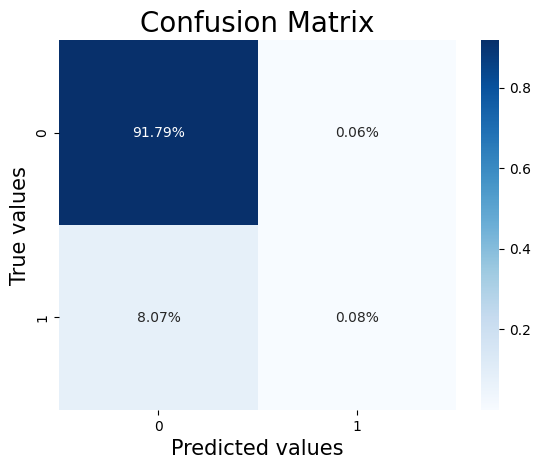

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     83907
           1       0.59      0.01      0.02      7451

    accuracy                           0.92     91358
   macro avg       0.75      0.50      0.49     91358
weighted avg       0.89      0.92      0.88     91358

ROC AUC Score: 0.50
Elapsed time:  30.860210452000047


In [ ]:
label = 'logistic_df_clean'
res, lm = scoring(df_scaled,clean_target, LogisticRegression(max_iter=5000), res, label)

<Axes: ylabel='Feature'>

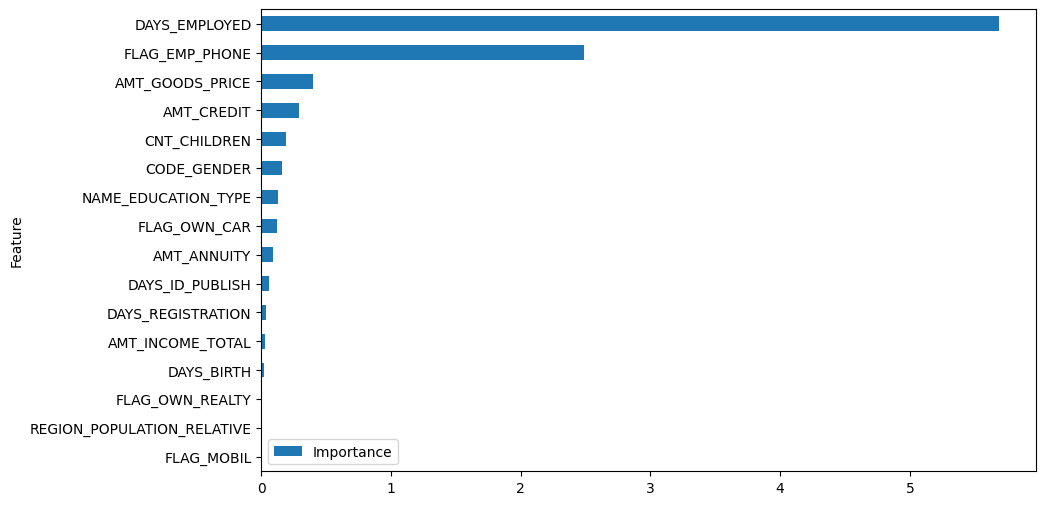

In [ ]:
coefficients = lm.coef_[0][0:16]
feature_importance = pd.DataFrame({'Feature': df_clean.columns[0:16], 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

We understand that for a binary classification, there exist only 2 possible choices. By default, if we just randomly guess, we would have a 50-50 chance. The same is happening here, the model using the data got a ROC AUC score of 0.51, essentially equal to randomly leave things for chances.
The model compeletely fail because the data is severely skewed toward TARGET = 0.
Intuitively think about this phenomenon, since the majority of the values are = 0, so the model automatically get a good accuracy just guessing **EVERYONE** as TARGET = 0, or will not default. To mitigate this problem, we have a few approach, including undersampling and oversampling to make the count of the 2 value type approximately equal to each other

### 2. Adjusting the dataset using oversampling

In [ ]:
#Splitting the dataset into the independent and dependent features
X = df_clean.drop('TARGET', axis=1)
y = df_clean['TARGET']

#Preparing the oversampler
oversampler = RandomOverSampler(random_state=42)

#creating the over samples for X and y
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

[[58064 25717]
 [27219 56916]]


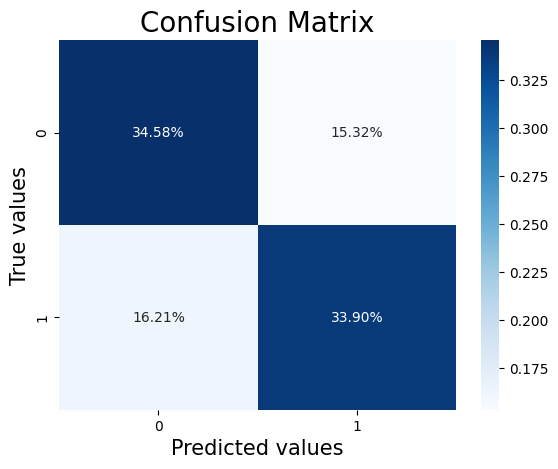

              precision    recall  f1-score   support

           0       0.68      0.69      0.69     83781
           1       0.69      0.68      0.68     84135

    accuracy                           0.68    167916
   macro avg       0.68      0.68      0.68    167916
weighted avg       0.68      0.68      0.68    167916

ROC AUC Score: 0.68
Elapsed time:  84.75458188199991


In [ ]:
label = 'logistic_oversampled'
res,model = scoring(X_oversampled, y_oversampled, LogisticRegression(max_iter=5000),res, label)

### 3. Adjusting the dataset using undersampling

In [ ]:
#Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

#Perform undersampling
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

[[5122 2313]
 [2344 5021]]


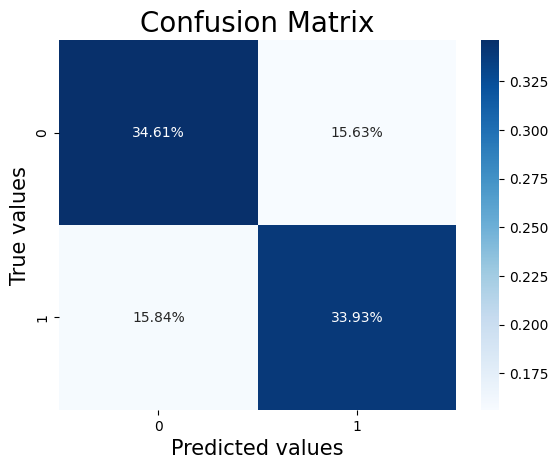

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      7435
           1       0.68      0.68      0.68      7365

    accuracy                           0.69     14800
   macro avg       0.69      0.69      0.69     14800
weighted avg       0.69      0.69      0.69     14800

ROC AUC Score: 0.69
Elapsed time:  3.1593228720003026


In [ ]:
label = 'logistic_undersampled'
res, logistic_model= scoring(X_undersampled,y_undersampled,LogisticRegression(max_iter=5000), res, label)

<Axes: title={'center': 'Feature importances in Logistic Classifier'}, ylabel='Feature'>

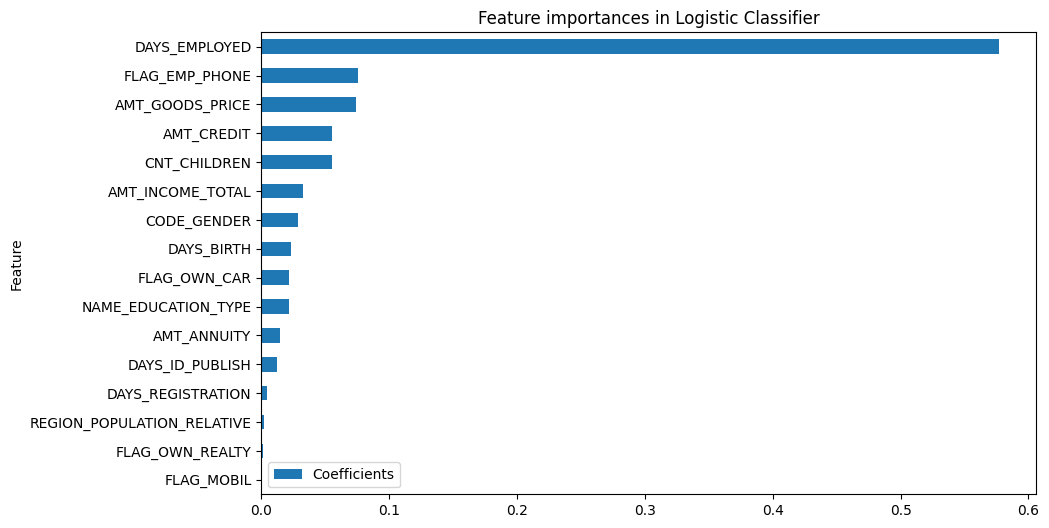

In [ ]:
coefficients = logistic_model.coef_[0][0:16]
coefficient = abs(coefficients) / sum(abs(coefficients))
feature_importance = pd.DataFrame({'Feature': df_clean.columns[0:16], 'Coefficients': np.abs(coefficient)})
feature_importance = feature_importance.sort_values('Coefficients', ascending=True)
feature_importance.plot(x='Feature', y='Coefficients', kind='barh', figsize=(10, 6), title ='Feature importances in Logistic Classifier')

Here we observe that both undersampling and oversampling return a relatively better result comparing to the first attempt. This happened because we have provide to the model enough samples of both type for the model to learn and thus have a relatively differentiation power.

### 4. Transforming the dataset via polynomial features

In [ ]:
#Select the top 15 most correlated columns (excluding 'TARGET' itself)
top_15_correlated = correlations[1:16].index.tolist()

#Extract the corresponding columns from the DataFrame
df_top15 = X_undersampled[top_15_correlated]

#Transformign the dataset via polynomial features
poly_engineer = PolynomialFeatures(degree = 3)
poly_engineer = poly_engineer.fit(df_top15)
train_poly_fea_15 = poly_engineer.transform(df_top15)

[[5052 2464]
 [2385 4899]]


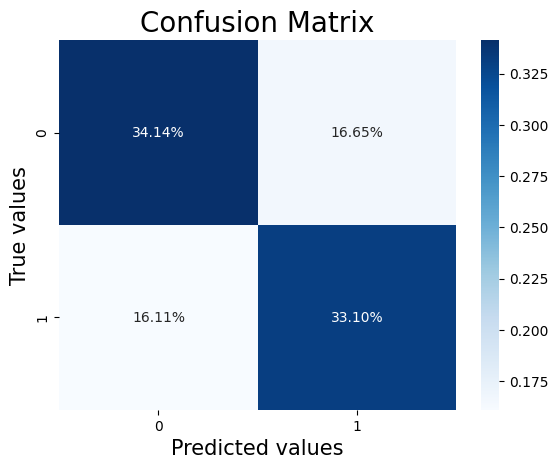

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      7516
           1       0.67      0.67      0.67      7284

    accuracy                           0.67     14800
   macro avg       0.67      0.67      0.67     14800
weighted avg       0.67      0.67      0.67     14800

ROC AUC Score: 0.67
Elapsed time:  80.37848157200006


({'logistic_df_clean': 0.5046559095294288,
  'logistic_oversampled': 0.6827250503101021,
  'logistic_undersampled': 0.6850328171243357,
  'logistic_poly': 0.6723680311217453},
 LogisticRegression(max_iter=5000))

In [ ]:
label = 'logistic_poly'
scoring(train_poly_fea_15, y_undersampled, LogisticRegression(max_iter=5000),res ,label)

In case the relationship between the TARGET and rest of the feature is not linear but exhibits a more complex, non-linear pattern, we could consider raising the current dataset to a specified degree

### 5. Trying with different supervised ML method

From the above datasets, we observed that undersampling help improve the F1 score while maintaining a small size. So from now we will be using the undersampled dataset with different supervised machine learning methods to see if there is any improvement


#### Decision Tree

[[4316 3113]
 [2979 4392]]


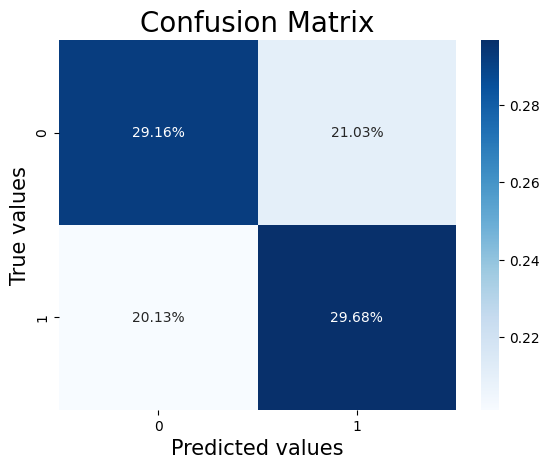

              precision    recall  f1-score   support

           0       0.59      0.58      0.59      7429
           1       0.59      0.60      0.59      7371

    accuracy                           0.59     14800
   macro avg       0.59      0.59      0.59     14800
weighted avg       0.59      0.59      0.59     14800

ROC AUC Score: 0.59
Elapsed time:  1.7220858020000378


In [ ]:
label = 'tree_undersampled'
res, tree_model = scoring(X_undersampled, y_undersampled, DecisionTreeClassifier(),res, label)

<Axes: title={'center': 'Feature importances in Decision Tree'}>

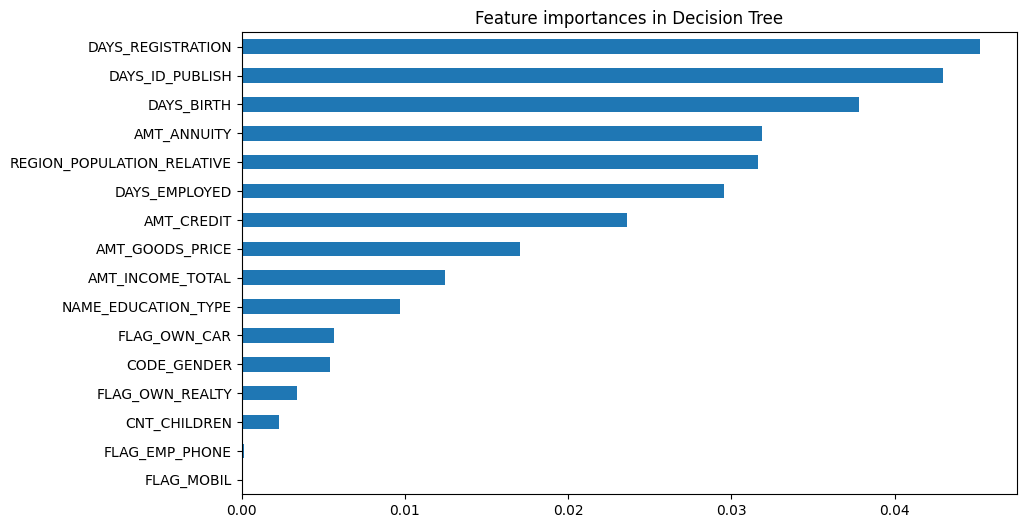

In [ ]:
feature_imp = pd.Series(tree_model.feature_importances_[0:16], index= df_clean.columns[0:16]).sort_values(ascending=True)

feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title = 'Feature importances in Decision Tree')

In [ ]:
X_undersampled.shape

(49332, 108)

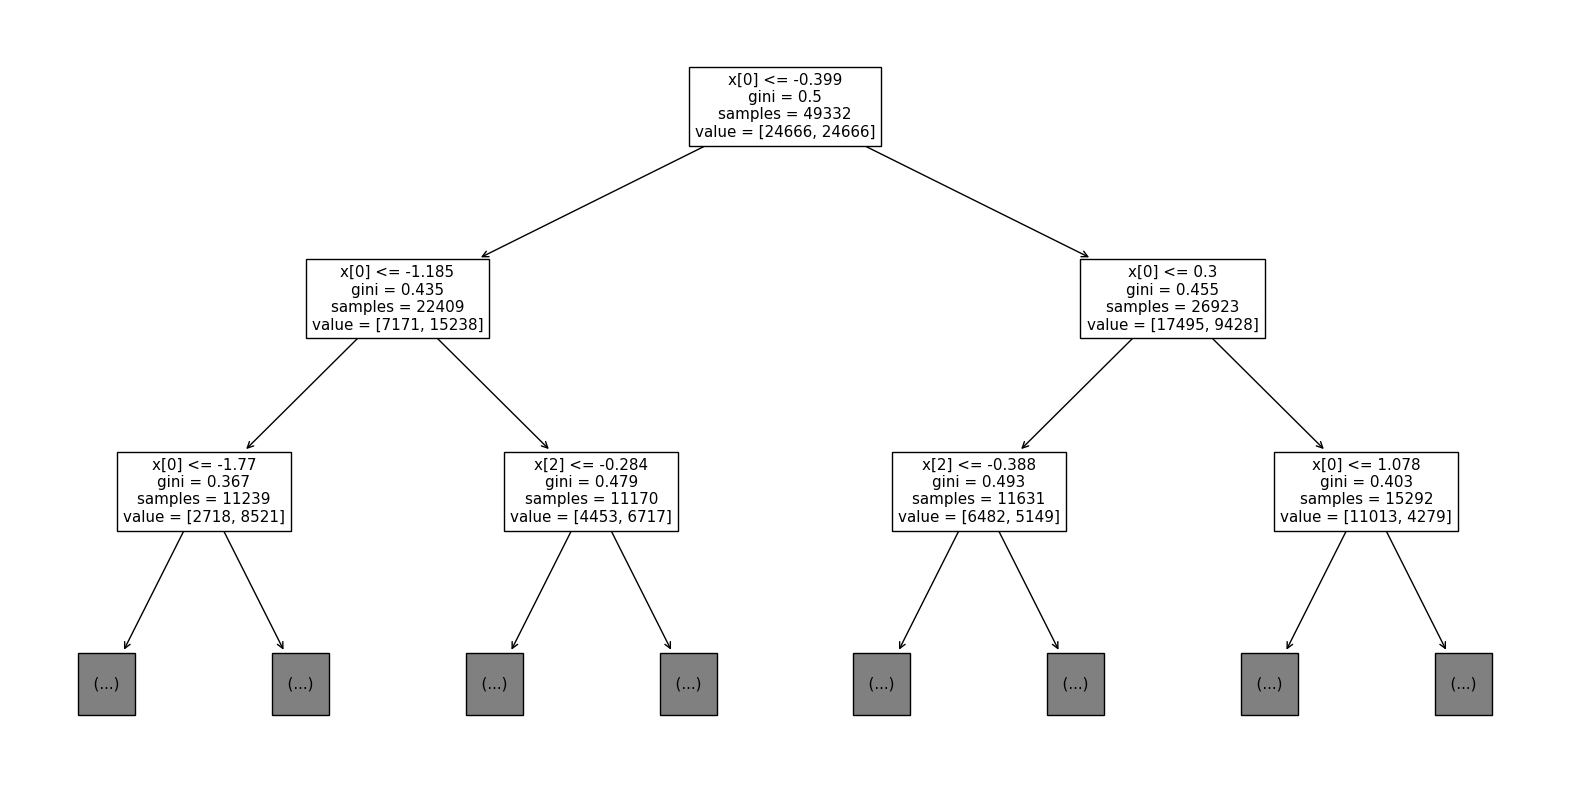

In [ ]:
from sklearn import tree
tree_sample = X_undersampled[['EXT_MEAN', 'DAYS_BIRTH', 'GOODS_CREDIT']]
model = DecisionTreeClassifier()
clf = model.fit(tree_sample, y_undersampled)
plt.figure(figsize=(20, 10))
tree.plot_tree(clf,max_depth = 2)
plt.show()

Decision Trees are good when interpretability is a primary concern and when we need a simple model to understand the decision-making process.
It is also possible to visualize the tree as shown on the above visualization

#### K-Neighbors

[[4573 2906]
 [2989 4332]]


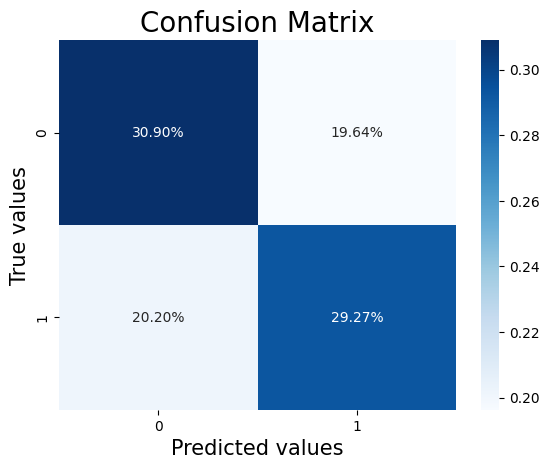

              precision    recall  f1-score   support

           0       0.60      0.61      0.61      7479
           1       0.60      0.59      0.60      7321

    accuracy                           0.60     14800
   macro avg       0.60      0.60      0.60     14800
weighted avg       0.60      0.60      0.60     14800

ROC AUC Score: 0.60
Elapsed time:  13.406350668999949


({'logistic_df_clean': 0.5046559095294288,
  'logistic_oversampled': 0.6827250503101021,
  'logistic_undersampled': 0.6850328171243357,
  'logistic_poly': 0.6723680311217453,
  'tree_undersampled': 0.5860138620528463,
  'KNN_undersampled': 0.6015839113438768},
 KNeighborsClassifier())

In [ ]:
label = 'KNN_undersampled'
scoring(X_undersampled,y_undersampled, KNeighborsClassifier(),res,label)

K-NN is sensitive to the scale of features, and with increasing number of features, the calculation process could increase exponentially as the distance metric increase. K-NN is also subseptible to imbalance dataset, such as the one we are working on.

#### Gaussian NB

[[7256  181]
 [7016  347]]


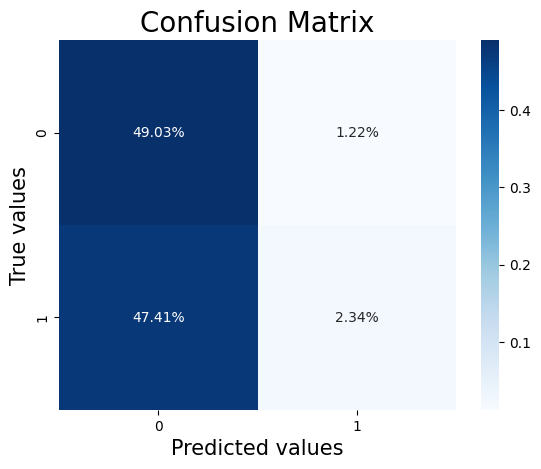

              precision    recall  f1-score   support

           0       0.51      0.98      0.67      7437
           1       0.66      0.05      0.09      7363

    accuracy                           0.51     14800
   macro avg       0.58      0.51      0.38     14800
weighted avg       0.58      0.51      0.38     14800

ROC AUC Score: 0.51
Elapsed time:  0.11256579499990949


({'logistic_df_clean': 0.5046559095294288,
  'logistic_oversampled': 0.6827250503101021,
  'logistic_undersampled': 0.6850328171243357,
  'logistic_poly': 0.6723680311217453,
  'tree_undersampled': 0.5860138620528463,
  'KNN_undersampled': 0.6015839113438768,
  'Gaussian_undersampled': 0.5113948794665814},
 GaussianNB())

In [ ]:
label = 'Gaussian_undersampled'
scoring(X_undersampled,y_undersampled,GaussianNB(),res,label)

So far this method has yield the worst result yet. There might be a few potential reasons for it:
1. The "Naive" in Naive Bayes refers to the assumption of feature independence. It assumes that each feature is independent of all others, But from the correlate heat map we create above, we have many features that are correlated or dependent on each other.
2. Distribution Assumptions: Gaussian Naive Bayes assumes that the features follow a Gaussian (normal) distribution. Since we already scaled the dataset using Standard scaler so we could expect somewhat better result but a lot of the feature may not be inhenrenly normally distributed

#### Random Forest

[[5118 2248]
 [2505 4929]]


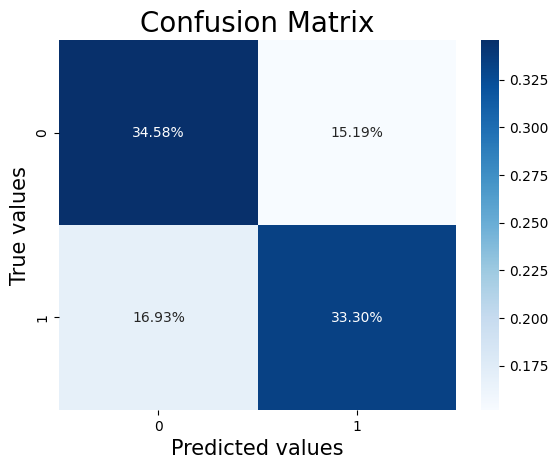

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      7366
           1       0.69      0.66      0.67      7434

    accuracy                           0.68     14800
   macro avg       0.68      0.68      0.68     14800
weighted avg       0.68      0.68      0.68     14800

ROC AUC Score: 0.68
Elapsed time:  23.818428831000347


In [ ]:
label = 'RandomForest_undersampled'
model = RandomForestClassifier(n_estimators=100, random_state=10)
res, forest_model = scoring(X_undersampled,y_undersampled,model,res,label)

<Axes: title={'center': 'Feature importances in Random Forest'}>

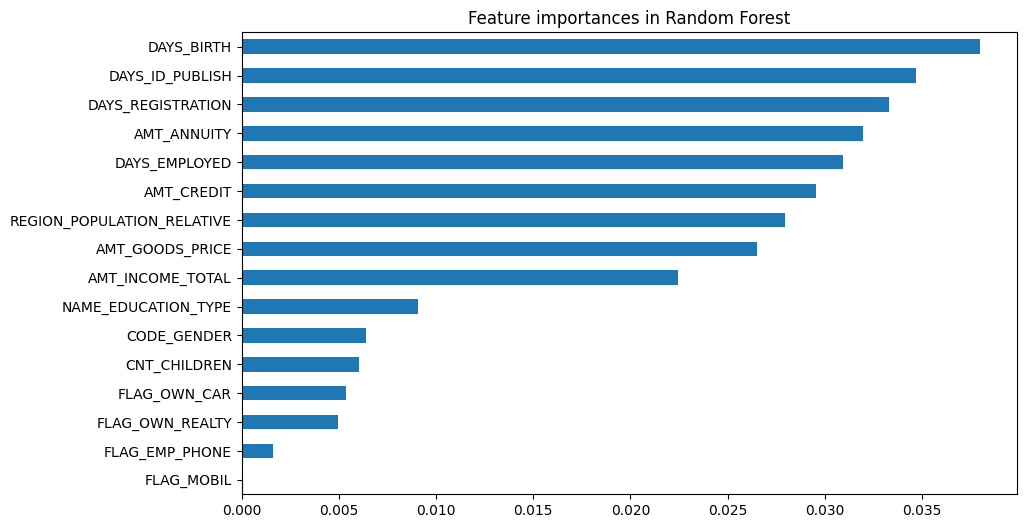

In [ ]:
feature_imp = pd.Series(forest_model.feature_importances_[0:16], index= df_clean.columns[0:16]).sort_values(ascending=True)

feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title = 'Feature importances in Random Forest')

Compare to decision tree, RandomForest is a ensemble learning method that combines multiple decision trees to produce a more robust and accurate model.

### 6. Removing the ext_source features

In [ ]:
#Removing features related to external sources, including EXTERNA_SOURCE_1/2/3 and engineered features
#Defining col to drop
columns_to_drop = [col for col in X_undersampled.columns if col.startswith("EXT")]

#Create a copy
X_remove_ext = X_undersampled.drop(columns=columns_to_drop)

[[4720 2614]
 [2774 4692]]


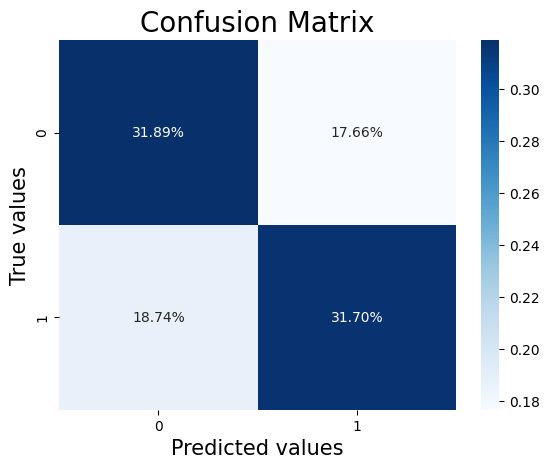

              precision    recall  f1-score   support

           0       0.63      0.64      0.64      7334
           1       0.64      0.63      0.64      7466

    accuracy                           0.64     14800
   macro avg       0.64      0.64      0.64     14800
weighted avg       0.64      0.64      0.64     14800

ROC AUC Score: 0.64
Elapsed time:  3.323492587000146


({'logistic_df_clean': 0.5046559095294288,
  'logistic_oversampled': 0.6827250503101021,
  'logistic_undersampled': 0.6850328171243357,
  'logistic_poly': 0.6723680311217453,
  'tree_undersampled': 0.5860138620528463,
  'KNN_undersampled': 0.6015839113438768,
  'Gaussian_undersampled': 0.5113948794665814,
  'RandomForest_undersampled': 0.679471356577188,
  'logistic_minus_ext': 0.6360134126082052},
 LogisticRegression(max_iter=5000))

In [ ]:
label = 'logistic_minus_ext'
scoring(X_remove_ext, y_undersampled, LogisticRegression(max_iter=5000), res, label)

### 7. Removing features relating to addresses/postcodes

In [ ]:
#Removing features related to external sources, including EXTERNA_SOURCE_1/2/3 and engineered features
#Create a copy
X_remove_address = X_undersampled.drop(columns=['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'])

[[5130 2316]
 [2378 4976]]


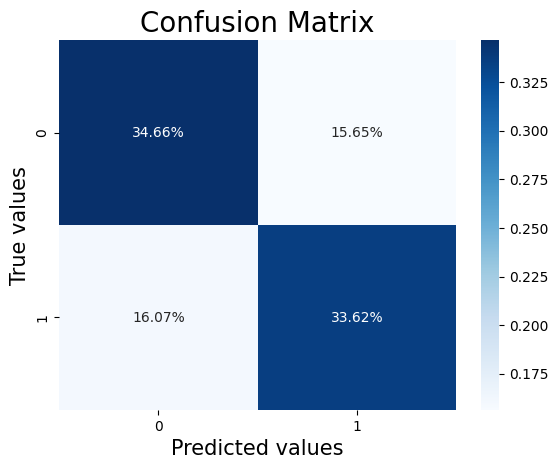

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      7446
           1       0.68      0.68      0.68      7354

    accuracy                           0.68     14800
   macro avg       0.68      0.68      0.68     14800
weighted avg       0.68      0.68      0.68     14800

ROC AUC Score: 0.68
Elapsed time:  4.853601903000026


({'logistic_df_clean': 0.5046559095294288,
  'logistic_oversampled': 0.6827250503101021,
  'logistic_undersampled': 0.6850328171243357,
  'logistic_poly': 0.6723680311217453,
  'tree_undersampled': 0.5860138620528463,
  'KNN_undersampled': 0.6015839113438768,
  'Gaussian_undersampled': 0.5113948794665814,
  'RandomForest_undersampled': 0.679471356577188,
  'logistic_minus_ext': 0.6360134126082052,
  'logistic_minus_address': 0.6827995398799559},
 LogisticRegression(max_iter=5000))

In [ ]:
label = 'logistic_minus_address'
scoring(X_remove_address, y_undersampled, LogisticRegression(max_iter=5000), res, label)

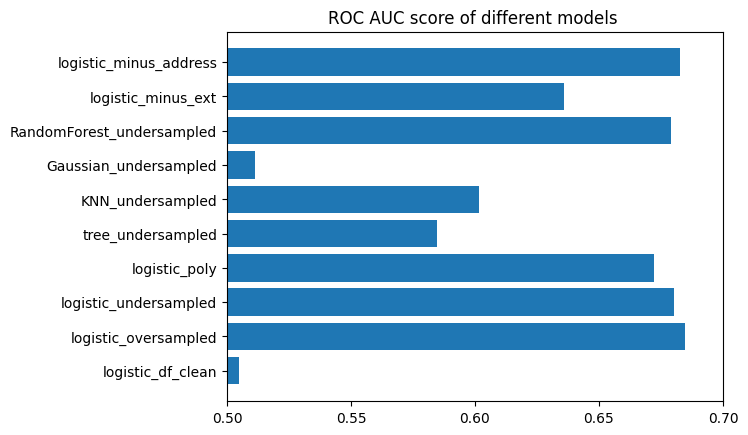

In [ ]:
plt.barh(list(res.keys()), [val - 0.5 for val in list(res.values())], left = 0.5)
plt.title('ROC AUC score of different models ')
plt.xticks([0.5,0.55,0.6,0.65,0.7])
plt.show()

In [ ]:
!python --version

Python 3.10.12
